# **ATE Estimation**

In this notebook, we will estimate the ATE, using the following methods:

- S-Learner

- T-Learner

- IPW

- DR-Learner

- X-Learner

- Matching

In each method, we will experiment with several architectures.

For each architecture, we would like to fine-tune its parameters. Hence, we will perfrom a 80%/20% train/test split (while stratifying by the treatment) and evaluate each parameter combination's performance by calculating the respective model's metric score. To minimize the effect of randomness, for each such combination we will calculate its average metric score across 10 different seeds.

Then, we will cross-compare each architecture's best performing model, and choose the best one.

*The dataset can be downloaded from the project's GitHub repository using the following [link](https://github.com/dan-israeli/Elections-and-Inflation-Causal-Inference-Research/blob/main/Data/dataset.csv)

In [1]:
# imports
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import roc_auc_score as ROC_AUC
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
### constants
YEARS = [year for year in range(2004, 2020)]
SEED_NUM = 10
COLORS = plt.cm.tab10.colors[:6]

### helper functions
def get_RMSE_score(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  rmse = MSE(y_test, y_pred)**0.5
  return round(rmse, 4)

def get_ROCAUC_score(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  y_pred_proba = model.predict_proba(X_test)

  roc_auc = ROC_AUC(y_test, y_pred_proba[:, 1])
  return round(roc_auc, 4)

def get_all_combos(lsts):
  def get_all_combos_recursive(lsts, sub_combo, combos):
    if len(lsts) == 0:
      combos.append(tuple(sub_combo))
      return

    for item in lsts[0]:
      get_all_combos_recursive(lsts[1:], sub_combo + [item], combos)

  combos = []
  get_all_combos_recursive(lsts, [], combos)
  return combos

def plot_heatmap(combo_metric_tups, param1_name, param2_name, title, reverse=False):
  param1 = [x[0][0] for x in combo_metric_tups]
  param2 = [x[0][1] for x in combo_metric_tups]
  metric = [x[1] for x in combo_metric_tups]

  df = pd.DataFrame({param1_name: param1, param2_name: param2, "Metric": metric})
  df = df.pivot(index=param1_name, columns=param2_name, values="Metric")

  cmap = "Blues_r" if reverse else "Blues"
  sns.heatmap(df, cmap=cmap, linewidths=1, linecolor='black')
  plt.title(title)
  plt.show()

def display_best_combo(combo_lst, model_name, param1_name, param2_name, metric):
  if metric == "RMSE":
    best_combo, best_score = min(combo_lst, key=lambda x: x[1])

  elif metric == "ROC AUC":
    best_combo, best_score = max(combo_lst, key=lambda x: x[1])

  print(f"------------{model_name}------------")
  print(f"Best {param1_name}: {best_combo[0]}")
  print(f"Best {param2_name}: {best_combo[1]}")
  print(f"Best {metric}: {best_score:.3f}")

def plot_yearly_ATE(year_ATE_lst, ATE, CIs, method, color):
  plt.figure(figsize=(9, 6))

  plt.plot(YEARS, year_ATE_lst, color=color)

  plt.axhline(ATE, linewidth=1, linestyle="--", color="red", label="ATE")

  lowers = CIs[:, 0]
  uppers = CIs[:, 1]
  plt.fill_between(YEARS, lowers, uppers, alpha=0.3, label="CI", color=color)

  plt.title(f"{method} - Yearly ATE")
  plt.xlabel("year")
  plt.ylabel("yearly ATE")

  plt.legend()
  plt.show()

def bootstrap_group(group, b):
  group_t0 = group[group["Is Election Year"] == 0]
  group_t1 = group[group["Is Election Year"] == 1]

  group_t0_bootstrapped_sample = group_t0.sample(frac=1, replace=True, random_state=b)
  group_t1_bootstrapped_sample = group_t1.sample(frac=1, replace=True, random_state=b)

  group_bootstrapped_sample = pd.concat([group_t0_bootstrapped_sample, group_t1_bootstrapped_sample])
  group_bootstrapped_sample = group_bootstrapped_sample.sample(frac=1, replace=False, random_state=b)

  return group_bootstrapped_sample

def get_bootstrapped_sample(data, b):
  bootstrapped_sample = data.groupby("Year").apply(lambda group: bootstrap_group(group, b))\
                            .reset_index(drop=True)

  return bootstrapped_sample

def get_CI_bootstrap(data, yearly_ATE_method, B):
  yearly_ATE_lsts = []

  for b in range(B):
    bootstrapped_sample = get_bootstrapped_sample(data, b)

    yearly_ATE_lst_b = yearly_ATE_method(bootstrapped_sample)
    yearly_ATE_lsts.append(np.array(yearly_ATE_lst_b))

  yearly_ATE_lsts = np.array(yearly_ATE_lsts)
  yearly_ATE_CIs = np.percentile(yearly_ATE_lsts, [2.5, 97.5], axis=0)

  ATE_lst = np.mean(yearly_ATE_lsts, axis=1)
  ATE_CI = np.percentile(ATE_lst, [2.5, 97.5])

  return yearly_ATE_CIs.T, ATE_CI

In [3]:
data = pd.read_csv("dataset.csv")
data.head(5)

,Country,Year,Is Election Year,Years Since Last Election,Inflation Rate,Previous Year Inflation Rate,GDP Per Capita,Previous Year GDP Per Capita,Currency is Euro,Previous Year Currency is Euro,...,EUR-USD Exchange Rate Q1,EUR-USD Exchange Rate Q2,EUR-USD Exchange Rate Q3,EUR-USD Exchange Rate Q4,Previous Year EUR-USD Exchange Rate Q1,Previous Year EUR-USD Exchange Rate Q2,Previous Year EUR-USD Exchange Rate Q3,Previous Year EUR-USD Exchange Rate Q4,ECB Interest Rate,Previous Year ECB Interest Rate
0,Austria,2004,0,2,2.061,1.356,36889.234,32294.049,1,1,...,1.25,1.205,1.222,1.298,1.073,1.137,1.125,1.189,2.0,2.259
1,Belgium,2004,0,1,2.097,1.589,35429.408,30655.209,1,1,...,1.25,1.205,1.222,1.298,1.073,1.137,1.125,1.189,2.0,2.259
2,Cyprus,2004,0,3,2.286,4.139,23792.621,20252.238,0,0,...,1.25,1.205,1.222,1.298,1.073,1.137,1.125,1.189,2.0,2.259
3,Czech Republic,2004,0,2,2.760,0.119,11749.853,9818.568,0,0,...,1.25,1.205,1.222,1.298,1.073,1.137,1.125,1.189,2.0,2.259
4,Denmark,2004,0,3,1.154,2.075,46511.598,40458.777,0,0,...,1.25,1.205,1.222,1.298,1.073,1.137,1.125,1.189,2.0,2.259


## **S-Learner**

In this method, we fit a single ML model to predict the outcome variable using all confounders, as well as the treatment, as features. Then, for each instance, we use the model to estimate the outcome of each group (by forcing T=0 and T=1 respectively).

Note that in this approach, the observed outcome is not utilized in the ATE calculation. However, by using the predictions of both groups, it is reasonable to assume that some model biases are cancelled out.

 We will experiment with the following ML architectures:

- Random Forest
- AdaBoost
- Gradient Boosting

*Note that we do not consider the linear regression model, since our features contain a high degree of multicollinearity.

Let us define a helper functions to assist us in the fine-tuning process:

In [4]:
### helper functions
def get_S_learner_X_y(data):
  S_learner_X = data.drop(["Country", "Inflation Rate"], axis=1)
  S_learner_y = data["Inflation Rate"]

  return S_learner_X, S_learner_y

def get_RMSE_for_each_combo(combos, create_model, data):
  X, y = get_S_learner_X_y(data)

  avg_rmse_lst = []
  for i, combo in enumerate(combos):
    summ = 0
    for seed in range(SEED_NUM):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed,
                                                          stratify=X["Is Election Year"])

      model = create_model(combo, seed)
      rmse = get_RMSE_score(model, X_train, y_train, X_test, y_test)
      summ += rmse

    avg_rmse = summ / SEED_NUM
    avg_rmse_lst.append((combo, avg_rmse))

  return avg_rmse_lst

### **Random Forest**


For this architecture, we will consider fine-tuning the following parameters:

- Number of Trees

- Max Depth

First, let us define the model's creation function:

In [5]:
from sklearn.ensemble import RandomForestRegressor

def create_rf_regressor_model(combo, seed):
  n_estimators, max_depth = combo
  return RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=seed)

Now, let us define the desired parameter combinations:

In [ ]:
n_estimators_lst = [10, 100, 250, 500, 750, 1000]
max_depth_lst = [1, 5, 10, 35, 50, 75]

rf_combos = get_all_combos([n_estimators_lst, max_depth_lst])

Now, let us find each combination's RMSE score and plot the results:

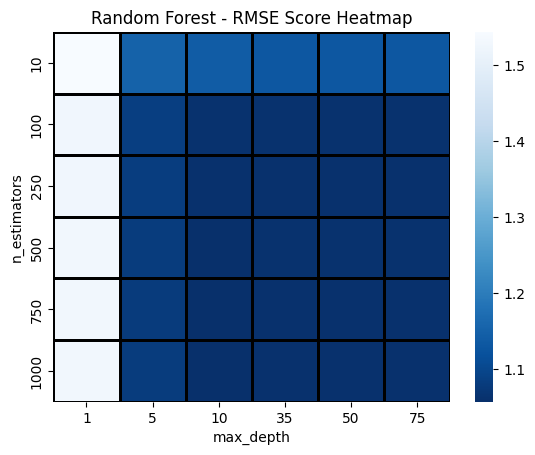

In [ ]:
rf_combo_avg_rmse_lst = get_RMSE_for_each_combo(rf_combos, create_rf_regressor_model, data)

title = "Random Forest - RMSE Score Heatmap"
plot_heatmap(rf_combo_avg_rmse_lst, param1_name="n_estimators", param2_name="max_depth",
             title=title, reverse=True)

As we can see, the best combination is at the buttom-right region.

Let us find the exact best combination:

In [ ]:
display_best_combo(rf_combo_avg_rmse_lst, "Random Forest", "Number of Estimators", "Max Depth", "RMSE")

------------Random Forest------------
Best Number of Estimators: 750
Best Max Depth: 10
Best RMSE: 1.057


### **AdaBoost**

For this architecture, we will consider fine-tuning the following parameters:

- Weak Learner Estimator

- Number of Estimators

First, let us define the model's creation function:

In [6]:
from sklearn.ensemble import AdaBoostRegressor

def create_ab_regressor_model(combo, seed):
  weak_learner_model, n_estimators = combo
  return AdaBoostRegressor(estimator=weak_learner_model, n_estimators=n_estimators, random_state=seed)

Now, let us define the desired parameter combinations:

In [7]:
from sklearn.tree import DecisionTreeRegressor

weak_learner_model_lst = [DecisionTreeRegressor(max_depth=1), DecisionTreeRegressor(max_depth=2),
                          DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=5),
                          DecisionTreeRegressor(max_depth=7), DecisionTreeRegressor(max_depth=10)]

n_estimators_lst = [10, 100, 200, 250, 500, 750]

ab_combos = get_all_combos([weak_learner_model_lst, n_estimators_lst])

Now, let us find each combination's average RMSE score and plot the results:

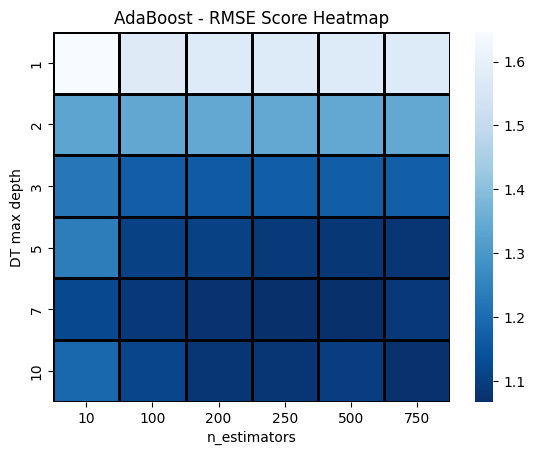

In [ ]:
ab_combo_avg_rmse_lst = get_RMSE_for_each_combo(ab_combos, create_ab_regressor_model, data)
ab_combo_avg_rmse_lst = [((x[0][0].max_depth, x[0][1]), x[1]) for x in ab_combo_avg_rmse_lst]

title = "AdaBoost - RMSE Score Heatmap"
plot_heatmap(ab_combo_avg_rmse_lst, param1_name="DT max depth", param2_name="n_estimators",
             title=title, reverse=True)

As we can see, the best combination is at the buttom-middle region.

Let us find the exact best combination:

In [ ]:
display_best_combo(ab_combo_avg_rmse_lst, "AdaBoost", "DT Max Depth", "Number of Estimators", "RMSE")

------------AdaBoost------------
Best DT Max Depth: 7
Best Number of Estimators: 250
Best RMSE: 1.068


### **Gradient Boosting**

For this architecture, we will consider fine-tuning the following parameters:

- Number of Estimators

- Max Depth

First, let us define the model's creation function:

In [8]:
from sklearn.ensemble import GradientBoostingRegressor

def create_gb_regressor_model(combo, seed):
  n_estimators, max_depth = combo
  return GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=seed)

Now, let us define the desired parameter combinations:

In [ ]:
n_estimators_lst = [5, 10, 20, 50, 75, 100, 150]
max_depth_lst = [1, 3, 5, 10, 20, 50, 75]

gb_combos = get_all_combos([n_estimators_lst, max_depth_lst])

Now, let us find each combination's average RMSE score and plot the results:

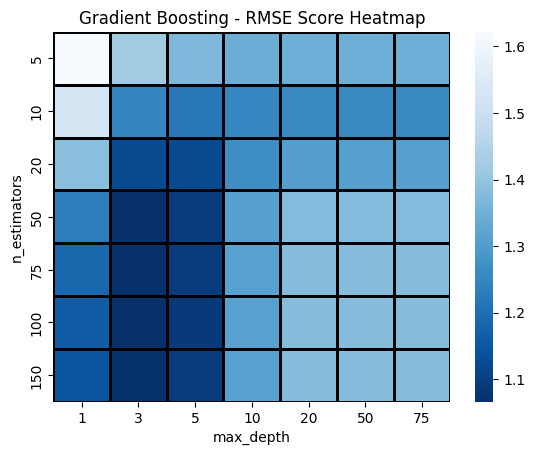

In [ ]:
gb_combo_avg_rmse_lst = get_RMSE_for_each_combo(gb_combos, create_gb_regressor_model, data)

title = "Gradient Boosting - RMSE Score Heatmap"
plot_heatmap(gb_combo_avg_rmse_lst, param1_name="n_estimators", param2_name="max_depth",
             title=title, reverse=True)

As we can see, the best combination is at the buttom-left region.

Let us find the exact best combination:

In [ ]:
display_best_combo(gb_combo_avg_rmse_lst, "Gradient Boosting", "Number of Estimators", "Max Depth", "RMSE")

------------Gradient Boosting------------
Best Number of Estimators: 75
Best Max Depth: 3
Best RMSE: 1.066


### **Calculating the ATE**

Let us summarize the results of each architecture's best model:

| Architecture  | RMSE |
|----------|----------|
| Random Forest   |1.057  |
| AdaBoost |1.068  |
| Gradient Boosting  |1.066  |

As we can see, the Random Forest architecture achieved the best performence.

As a result, for the S-learner method, we will use the following model:

**Random Forest with ```n_estimator=750``` and ```max_depth=10```**.

In [9]:
def get_best_S_learner_model_trained(data):
  # extract X and y
  X, y = get_S_learner_X_y(data)

  # fit the S-learner model
  S_learner_best_model =  RandomForestRegressor(n_estimators=750, max_depth=10, random_state=123)
  S_learner_best_model.fit(X, y)

  return S_learner_best_model


def get_S_learner_yearly_ATEs(data):
  # get the best S-learner model (trained)
  S_learner_best_model =  get_best_S_learner_model_trained(data)

  S_learner_year_ATE_lst = []
  for year in YEARS:
    # get yearly data
    year_data = data[data["Year"] == year]
    year_summ = 0

    for _, row in year_data.iterrows():
      x = pd.DataFrame(row.drop(["Inflation Rate", "Country"])).T

      # "force" the instance to be on the control group, and predict the outcome
      x0 = x.copy()
      x0["Is Election Year"] = 0
      y0_pred = S_learner_best_model.predict(x0)[0]

      # "force" the instance to be on the treatment group, and predict the outcome
      x1 = x.copy()
      x1["Is Election Year"] = 1
      y1_pred = S_learner_best_model.predict(x1)[0]

      # sum the difference
      year_summ += (y1_pred - y0_pred)

    # calculate the current yearly ATE
    year_ATE = year_summ / len(year_data)
    S_learner_year_ATE_lst.append(year_ATE)

  return S_learner_year_ATE_lst

In [10]:
S_learner_year_ATE_lst = get_S_learner_yearly_ATEs(data)

# calculate the ATE as the average of the yearly ATEs
S_learner_ATE = sum(S_learner_year_ATE_lst) / len(S_learner_year_ATE_lst)

print(f"ATE using the S-Learner method: {S_learner_ATE:.3f}")

ATE using the S-Learner method: -0.002


Now, let us find a 95% confidence interval for this result:

In [ ]:
S_learner_yearly_ATE_CIs, S_learner_ATE_CI = get_CI_bootstrap(data, get_S_learner_yearly_ATEs, B=500)

lower, upper = S_learner_ATE_CI
print(f"95% confidence interval for the ATE: [{lower:.3f}, {upper:.3f}]")

95% confidence interval for the ATE: [-0.018, 0.027]


Lastly, let us plot the yearly ATEs, along with their respective 95% confidence intervals:

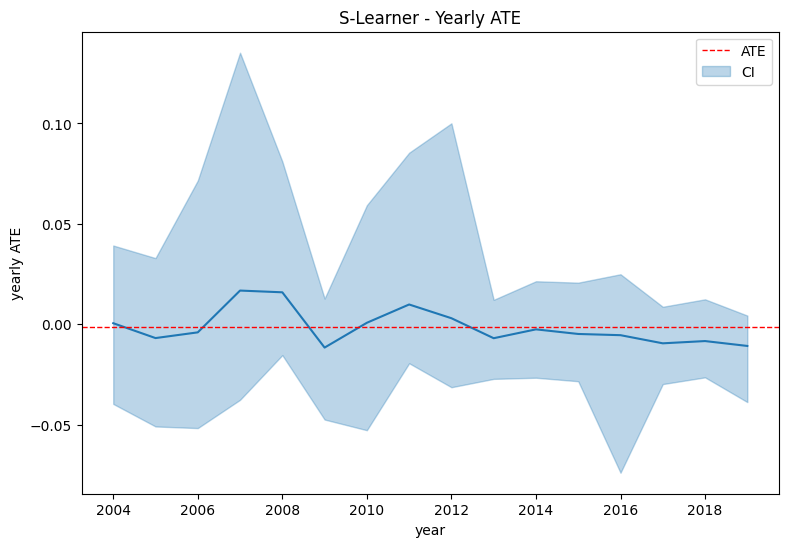

In [ ]:
plot_yearly_ATE(S_learner_year_ATE_lst, S_learner_ATE, S_learner_yearly_ATE_CIs, method="S-Learner", color=COLORS[0])

## **T-Learner**

In this method, we fit two separate ML models to predict the outcome variable using all confounders:

- Control model - trained only on the control group units, and predicts the outcomes for that group.

- Treatment model - trained only on the treatment group units, and predicts the outcomes for that group.

Then, for each unit, we estimate the outcome of each group using the corresponding model. That is, we used the same approach discussed in the S-Learner section.

We will experimente with the following ML architectures:

- Random Forest
- AdaBoost
- Gradient Boosting

Moreover, although this method requires two different models, in our eyes, it seems appropriate to use the same model architecture for both. However, we will fine-tune each model separately to capture each group’s unique characteristics.

*Note that again we do not consider the linear regression model, from the same reasons discussed in the previous section.

Let us define a helper functions to assist us in the fine-tuning process:

In [11]:
### helper functions
def get_T_learner_X_y(data):
  T_learner_X = data.drop(["Country", "Is Election Year", "Inflation Rate"], axis=1)
  T_learner_y = data["Inflation Rate"]

  return T_learner_X, T_learner_y

def get_T_learner_RMSE_for_each_combo(combos, create_model, data, t):
  group_data = data[data["Is Election Year"] == t]
  X, y = get_T_learner_X_y(group_data)

  avg_rmse_lst = []
  for i, combo in enumerate(combos):
    summ = 0
    for seed in range(SEED_NUM):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

      model = create_model(combo, seed)
      rmse = get_RMSE_score(model, X_train, y_train, X_test, y_test)
      summ += rmse

    avg_rmse = summ / SEED_NUM
    avg_rmse_lst.append((combo, avg_rmse))

  return avg_rmse_lst

### **Random Forest**

For this architecture, we will consider fine-tuning the following parameters:

- Number of Trees

- Max Depth

First, let us define the desired parameter combinations:

In [ ]:
n_estimators_lst = [10, 100, 250, 500, 750, 1000]
max_depth_lst = [1, 5, 10, 35, 50, 75]

rf_combos = get_all_combos([n_estimators_lst, max_depth_lst])

Now, let us find each combination's average RMSE score and plot the results:

**Control Group:**

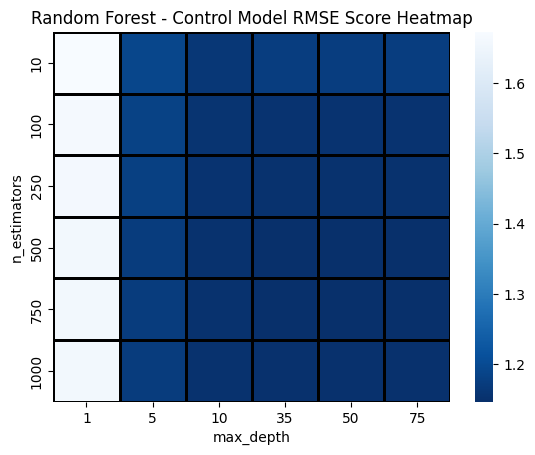

In [ ]:
control_rf_combo_avg_rmse_lst = get_T_learner_RMSE_for_each_combo(rf_combos, create_rf_regressor_model, data, t=0)

title = "Random Forest - Control Model RMSE Score Heatmap"
plot_heatmap(control_rf_combo_avg_rmse_lst, param1_name="n_estimators", param2_name="max_depth",
             title=title, reverse=True)

As we can see, the best combination is at the buttom-right region.

Let us find the exact best combination:

In [ ]:
display_best_combo(control_rf_combo_avg_rmse_lst, "Random Forest", "Number of Estimators", "Max Depth", "RMSE")

------------Random Forest------------
Best Number of Estimators: 750
Best Max Depth: 35
Best RMSE: 1.147


**Treatment Group:**

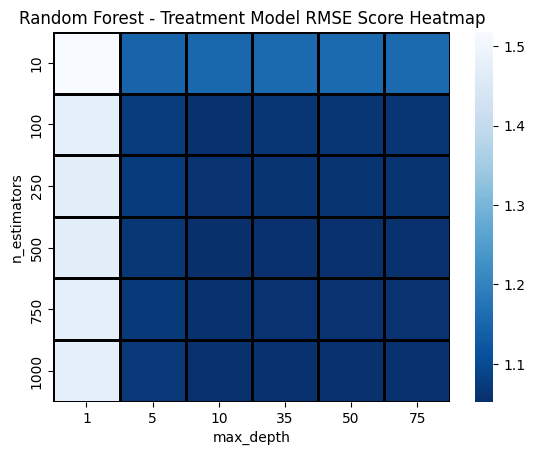

In [ ]:
treatment_rf_combo_avg_rmse_lst = get_T_learner_RMSE_for_each_combo(rf_combos, create_rf_regressor_model, data, t=1)

title = "Random Forest - Treatment Model RMSE Score Heatmap"
plot_heatmap(treatment_rf_combo_avg_rmse_lst, param1_name="n_estimators", param2_name="max_depth",
             title=title, reverse=True)

As we can see, the best combination is at the buttom-middle region.

Let us find the exact best combination:

In [ ]:
display_best_combo(treatment_rf_combo_avg_rmse_lst, "Random Forest", "Number of Estimators", "Max Depth", "RMSE")

------------Random Forest------------
Best Number of Estimators: 500
Best Max Depth: 10
Best RMSE: 1.052


### **AdaBoost**

For this architecture, we will consider fine-tuning the following parameters:

- Weak Learner Estimator

- Number of Estimators

First, let us define the desired parameter combinations:

In [ ]:
weak_learner_model_lst = [DecisionTreeRegressor(max_depth=1), DecisionTreeRegressor(max_depth=2),
                          DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=5),
                          DecisionTreeRegressor(max_depth=7), DecisionTreeRegressor(max_depth=10)]

n_estimators_lst = [10, 100, 200, 250, 500, 750]

ab_combos = get_all_combos([weak_learner_model_lst, n_estimators_lst])

Now, let us find each combination's average RMSE score and plot the results:

**Control Group:**

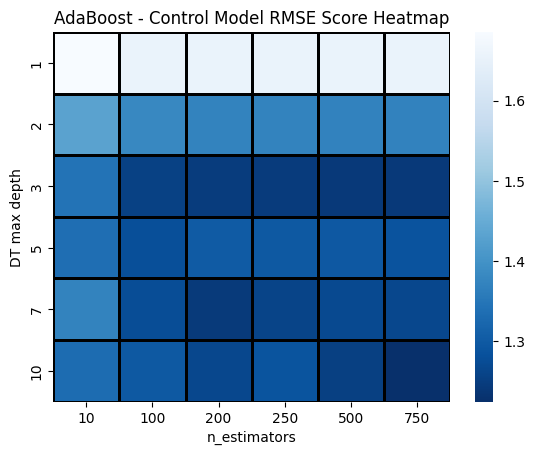

In [ ]:
control_ab_combo_avg_rmse_lst = get_T_learner_RMSE_for_each_combo(ab_combos, create_ab_regressor_model, data, t=0)
control_ab_combo_avg_rmse_lst = [((x[0][0].max_depth, x[0][1]), x[1]) for x in control_ab_combo_avg_rmse_lst]

title = "AdaBoost - Control Model RMSE Score Heatmap"
plot_heatmap(control_ab_combo_avg_rmse_lst, param1_name="DT max depth", param2_name="n_estimators",
             title=title, reverse=True)

As we can see, the best combination is at the buttom-right region.

Let us find the exact best combination:

In [ ]:
display_best_combo(control_ab_combo_avg_rmse_lst, "AdaBoost", "DT Max Depth", "Number of Estimators", "RMSE")

------------AdaBoost------------
Best DT Max Depth: 10
Best Number of Estimators: 750
Best RMSE: 1.224


**Treatment Group:**

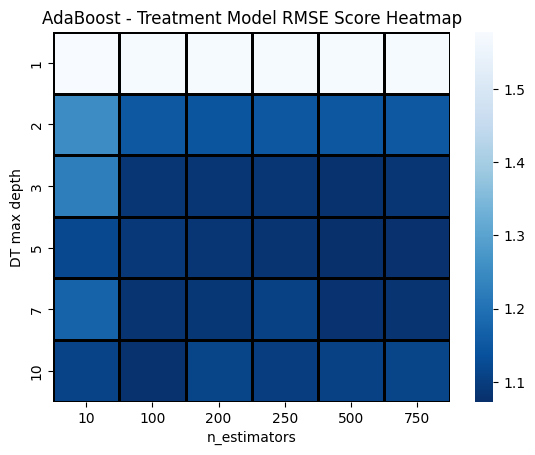

In [ ]:
treatment_ab_combo_avg_rmse_lst = get_T_learner_RMSE_for_each_combo(ab_combos, create_ab_regressor_model, data, t=1)
treatment_ab_combo_avg_rmse_lst = [((x[0][0].max_depth, x[0][1]), x[1]) for x in treatment_ab_combo_avg_rmse_lst]

title = "AdaBoost - Treatment Model RMSE Score Heatmap"
plot_heatmap(treatment_ab_combo_avg_rmse_lst, param1_name="DT max depth", param2_name="n_estimators",
             title=title, reverse=True)

As we can see, the best combination is at the buttom-right region.

Let us find the exact best combination:

In [ ]:
display_best_combo(treatment_ab_combo_avg_rmse_lst, "AdaBoost", "DT Max Depth", "Number of Estimators", "RMSE")

------------AdaBoost------------
Best DT Max Depth: 5
Best Number of Estimators: 500
Best RMSE: 1.073


### **Gradient Boosting**

For this architecture, we will consider fine-tuning the following parameters:

- Number of Estimators

- Max Depth

First, let us define the desired parameter combinations:

In [ ]:
n_estimators_lst = [5, 10, 20, 50, 75, 100, 150]
max_depth_lst = [1, 3, 5, 10, 20, 50, 75]

gb_combos = get_all_combos([n_estimators_lst, max_depth_lst])

Now, let us find each combination's average RMSE score and plot the results:

**Control Group**:

Now, let us find each combination's average RMSE score and plot the results:

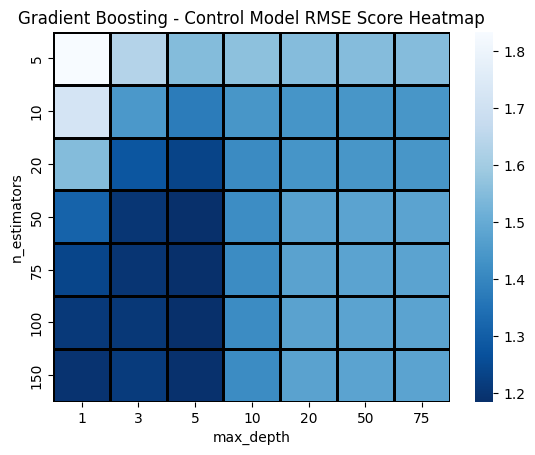

In [ ]:
control_gb_combo_avg_rmse_lst = get_T_learner_RMSE_for_each_combo(gb_combos, create_gb_regressor_model, data, t=0)

title = "Gradient Boosting - Control Model RMSE Score Heatmap"
plot_heatmap(control_gb_combo_avg_rmse_lst, param1_name="n_estimators", param2_name="max_depth",
             title=title, reverse=True)

As we can see, the best combination is at the buttom-left region.

Let us find the exact best combination:

In [ ]:
display_best_combo(control_gb_combo_avg_rmse_lst, "Gradient Boosting", "Number of Estimators", "Max Depth", "RMSE")

------------Gradient Boosting------------
Best Number of Estimators: 75
Best Max Depth: 5
Best RMSE: 1.185


**Treatment Group:**

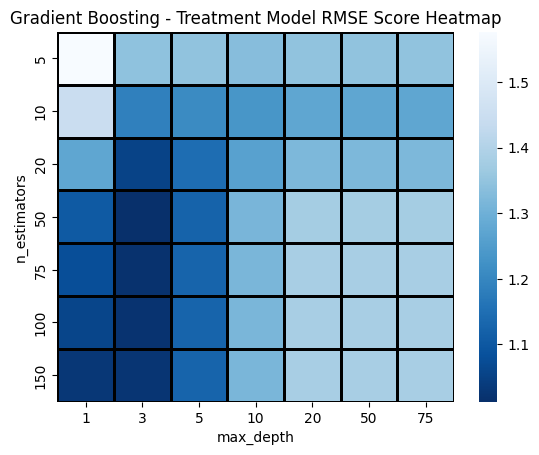

In [ ]:
treatment_gb_combo_avg_rmse_lst = get_T_learner_RMSE_for_each_combo(gb_combos, create_gb_regressor_model, data, t=1)

title = "Gradient Boosting - Treatment Model RMSE Score Heatmap"
plot_heatmap(treatment_gb_combo_avg_rmse_lst, param1_name="n_estimators", param2_name="max_depth",
             title=title, reverse=True)

As we can see, the best combination is at the buttom-left region.

Let us find the exact best combination:

In [ ]:
display_best_combo(treatment_gb_combo_avg_rmse_lst, "Gradient Boosting", "Number of Estimators", "Max Depth", "RMSE")

------------Gradient Boosting------------
Best Number of Estimators: 50
Best Max Depth: 3
Best RMSE: 1.013


### **Calculating the ATE**

Let us summarize the results of each architecture's best models:

| Architecture  | RMSE Control | RMSE Treatment | RMSE Average |
|----------|----------|----------|----------|
| Random Forest|1.147  |1.052|1.0995|
| AdaBoost |1.224| 1.073|1.1485|
| Gradient Boosting  |1.185|1.013|1.099|

As we can see, the Gradient Boosting architecture achieved the best performance.

As a result, for the T-learner method, we will use the Gradient Boosting model with:

- **Control - ```n_estimator=75``` and ```max_depth=5```**

- **Treatment - ```n_estimator=50``` and ```max_depth=3```**

In [12]:
def get_best_T_learner_model_trained(data, t):
  # get group data
  data_t = data[data["Is Election Year"] == t]

  # get X and y
  X, y = get_T_learner_X_y(data_t)

  # the best control group model
  if t == 0:
    T_learner_best_model = GradientBoostingRegressor(n_estimators=75, max_depth=5, random_state=123)

  # the best treatment group model
  else:
    T_learner_best_model = GradientBoostingRegressor(n_estimators=50, max_depth=3, random_state=123)

  # fit the model
  T_learner_best_model.fit(X, y)

  return T_learner_best_model

def get_T_learner_yearly_ATEs(data):
  # get best control group T-learner model (tranied)
  T_learner_best_model_0 = get_best_T_learner_model_trained(data, t=0)
  # get best treatment group T-learner model (tranied)
  T_learner_best_model_1 = get_best_T_learner_model_trained(data, t=1)

  T_learner_year_ATE_lst = []
  for year in YEARS:
    # get the yearly data
    year_data = data[data["Year"] == year]
    year_summ = 0

    for _, row in year_data.iterrows():
      x = pd.DataFrame(row.drop(["Inflation Rate", "Country", "Is Election Year"])).T

      # predict the control group outcome
      y0_pred = T_learner_best_model_0.predict(x)[0]

      # predict the treatment group outcome
      y1_pred = T_learner_best_model_1.predict(x)[0]

      # sum the difference
      year_summ += (y1_pred - y0_pred)

    # calculate the current yearly ATE
    year_ATE = year_summ / len(year_data)
    T_learner_year_ATE_lst.append(year_ATE)

  return T_learner_year_ATE_lst

In [13]:
T_learner_year_ATE_lst = get_T_learner_yearly_ATEs(data)

# calculate the ATE as the average yearly ATEs
T_learner_ATE = sum(T_learner_year_ATE_lst) / len(T_learner_year_ATE_lst)

print(f"ATE using the T-Learner method: {T_learner_ATE:.3f}")

ATE using the T-Learner method: 0.036


Now, let us find a 95% confidence interval for this result:

In [ ]:
T_learner_yearly_ATE_CIs, T_learner_ATE_CI = get_CI_bootstrap(data, get_T_learner_yearly_ATEs, B=500)

lower, upper = T_learner_ATE_CI
print(f"95% confidence interval for the ATE: [{lower:.3f}, {upper:.3f}]")

95% confidence interval for the ATE: [-0.129, 0.219]


Lastly, let us plot the yearly ATEs, along with their respective 95% confidence intervals:

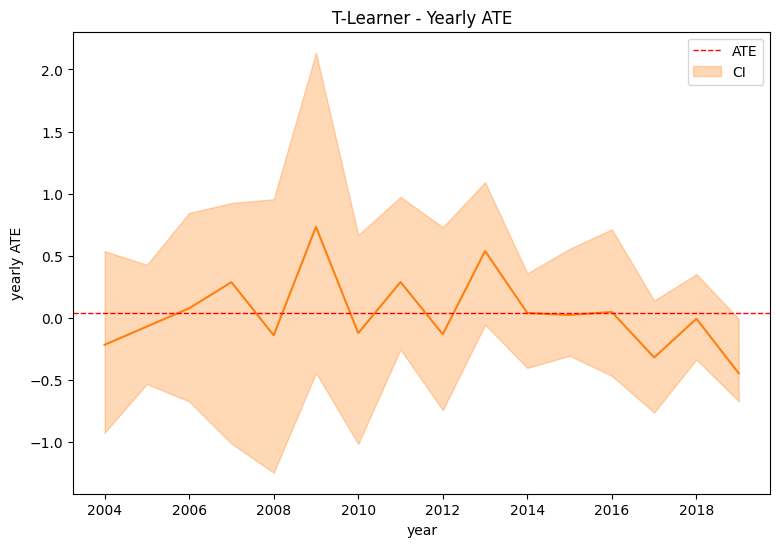

In [ ]:
plot_yearly_ATE(T_learner_year_ATE_lst, T_learner_ATE, T_learner_yearly_ATE_CIs, method="T-Learner", color=COLORS[1])

## **IPW**

In this method, we fit a model to estimate the propensity scores using all confounders. That is, for each instance, we estimate its probability to be in the treatment group, given its confounders values. Then, we weight each instance’s outcome with the inverse estimated respective probability. Lastly, we calculated the difference between the normalized  weighted sum of the control and treatment groups.

Note that the control and treatment groups are imbalanced (treatment group accounts for 25% of the data). To take this imbalance into account in the ATE calculation, we will normalize each group's weighted outcome sum, by the inverse of their total IPW sum.

We will experiment with the following ML architectures:

- Logistic Regression
- Random Forest
- Gradient Boosting



Let us define a helper function to assist us in the fine-tuning process:

In [14]:
### helper functions
def get_IPW_X_y(data):
  IPW_X = data.drop(["Country", "Is Election Year", "Inflation Rate"], axis=1)
  IPW_y = data["Is Election Year"]

  return IPW_X, IPW_y

def get_ROCAUC_for_each_combo(combos, create_model, data):
  X, y = get_IPW_X_y(data)

  avg_rmse_lst = []
  for i, combo in enumerate(combos):
    summ = 0

    for seed in range(SEED_NUM):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed,
                                                          stratify=y)
      model = create_model(combo, seed)
      rmse = get_ROCAUC_score(model, X_train, y_train, X_test, y_test)
      summ += rmse

    avg_rmse = summ / SEED_NUM
    avg_rmse_lst.append((combo, avg_rmse))

  return avg_rmse_lst

def plot_propensity_score_histograms(model, dataset, model_name):
  X = dataset.drop(["Country", "Is Election Year", "Inflation Rate"], axis=1)
  y = dataset["Is Election Year"]

  model.fit(X, y)

  X_0 = dataset[dataset["Is Election Year"] == 0].drop(["Country", "Is Election Year", "Inflation Rate"], axis=1)
  X_1 = dataset[dataset["Is Election Year"] == 1].drop(["Country", "Is Election Year", "Inflation Rate"], axis=1)

  control_group_prop = model.predict_proba(X_0)[:, 1]
  treatment_group_prop = model.predict_proba(X_1)[:, 1]

  plt.figure(figsize=(9, 5))

  sns.histplot(control_group_prop, bins=7, color="blue", label="control", alpha=0.5)
  sns.histplot(treatment_group_prop, bins=7, color="red", label="treatment", alpha=0.5)

  plt.title(f"{model_name} - Propensity Score Histogram")
  plt.legend()
  plt.show()

### **Logistic Regression**

For this architecture, we will consider fine-tuning the following parameters:

- C (Regularization)

- Penalty Type

*Note that we will use the liblinear solver and a balanced class weighting.

First, let us define the model's creation function:

In [15]:
from sklearn.linear_model import LogisticRegression

def create_lr_model(combo, seed):
  C, penalty = combo
  lr_model = LogisticRegression(C=C, penalty=penalty, solver="liblinear",
                          max_iter=5000, class_weight="balanced", random_state=seed)
  return lr_model

Now, let us define the desired parameter combinations:

In [ ]:
C_lst = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10]
penalty_lst = ["l1", "l2"]

lr_combos = get_all_combos([C_lst, penalty_lst])

Now, let us find each combinations ROC AUC score and plot the results:

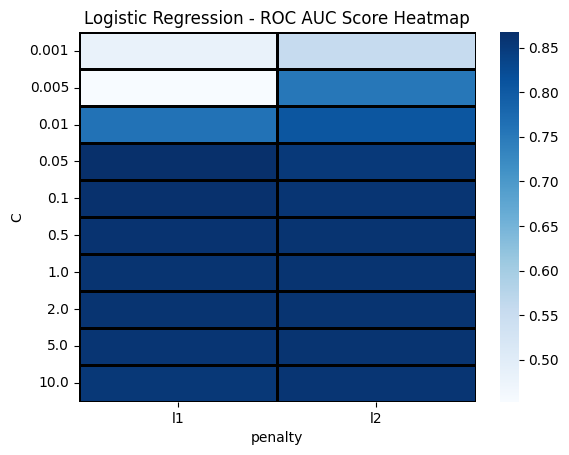

In [ ]:
lr_combo_avg_rocauc_lst = get_ROCAUC_for_each_combo(lr_combos, create_lr_model, data)

title = "Logistic Regression - ROC AUC Score Heatmap"
plot_heatmap(lr_combo_avg_rocauc_lst, param1_name="C", param2_name="penalty",
             title=title)

As we can see, the best combination is at the buttom-left region.

Let us find the exact best combination:

In [ ]:
display_best_combo(lr_combo_avg_rocauc_lst, "Logistic Regression", "C", "Penalty", "ROC AUC")

------------Logistic Regression------------
Best C: 0.05
Best Penalty: l1
Best ROC AUC: 0.867


Lastly, let us plot the propensity score histograms for both groups:

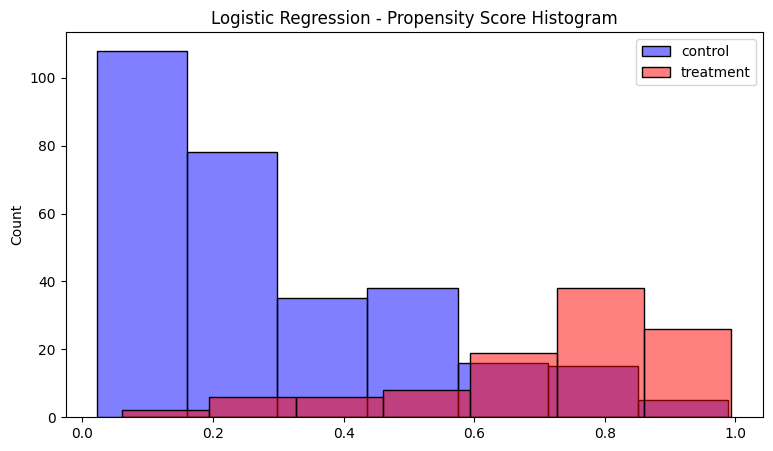

In [ ]:
best_lr_model = LogisticRegression(C=0.05, penalty="l1", solver="liblinear",
                                   max_iter=5000, class_weight="balanced", random_state=123)
plot_propensity_score_histograms(best_lr_model, data, model_name="Logistic Regression")

As we can see, the Overlap requirement indeed holds. That is:

- Both the control and treatment groups have a representation in any of the propensity score buckets.

- For the control group, the instances count is decreasing as the propensity score is increasing.

- For the treatment group, the instances count is increasing as the propensity score is increasing.

*Note that the sizes of the groups are imbalanced. Therefore, this causes the histograms to be less symmetrical in size.

### **Random Forest**

For this architecture, we will consider fine-tuning the following parameters:

- Number of Trees

- Max Depth

First, let us define the model's creation function:

In [16]:
from sklearn.ensemble import RandomForestClassifier

def create_rf_classifier_model(combo, seed):
  n_estimators, max_depth = combo
  rf_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=seed)

  return rf_model

Now, let us define the desired parameter combinations:

In [ ]:
n_estimators_lst = [10, 100, 250, 500, 750, 1000]
max_depth_lst = [1, 5, 10, 35, 50, 75]

rf_combos = get_all_combos([n_estimators_lst, max_depth_lst])

Now, let us find each combination's RMSE score and plot the results:

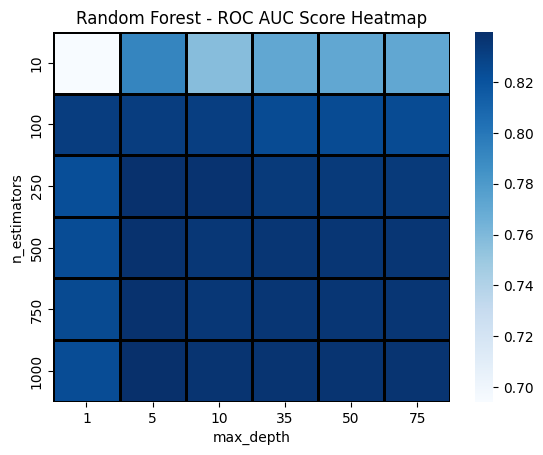

In [ ]:
rf_combo_avg_rocauc_lst = get_ROCAUC_for_each_combo(rf_combos, create_rf_classifier_model, data)

title = "Random Forest - ROC AUC Score Heatmap"
plot_heatmap(rf_combo_avg_rocauc_lst, param1_name="n_estimators", param2_name="max_depth",
             title=title)

As we can see, the best combination is at the buttom-left region.

Let us find the exact best combination:

In [ ]:
display_best_combo(rf_combo_avg_rocauc_lst, "Random Forest", "Number of Estimators", "Max Depth", "ROC AUC")

------------Random Forest------------
Best Number of Estimators: 1000
Best Max Depth: 5
Best ROC AUC: 0.840


Lastly, let us plot the propensity score histograms for both groups:

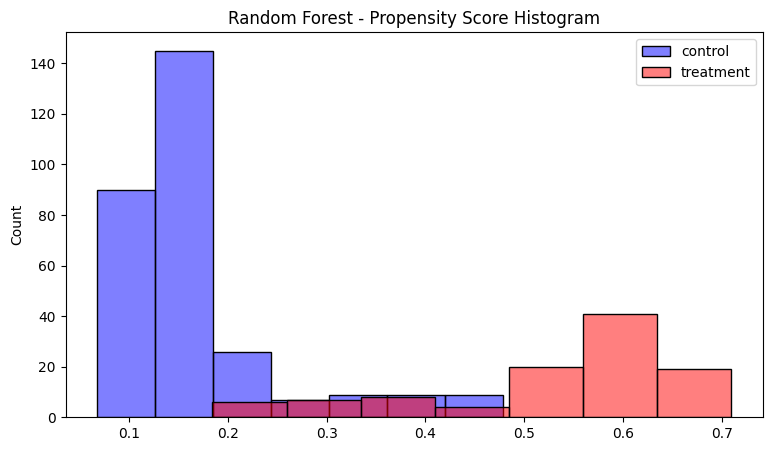

In [ ]:
best_rf_model = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=123)
plot_propensity_score_histograms(best_rf_model, data, model_name="Random Forest")

As we can, the Overlap requirement does not hold.

### **Gradient Boosting**

For this architecture, we will consider fine-tuning the following parameters:

- Number of Estimators

- Max Depth

First, let us define the model's creation function:

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

def create_gb_classifier_model(combo, seed):
  n_estimators, max_depth = combo
  gb_model = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=seed)

  return gb_model

Now, let us define the desired parameter combinations:

In [ ]:
n_estimators_lst = [5, 10, 20, 50, 75, 100, 150]
max_depth_lst = [1, 3, 5, 10, 20, 50, 75]

gb_combos = get_all_combos([n_estimators_lst, max_depth_lst])

Now, let us find each combination's RMSE score and plot the results:

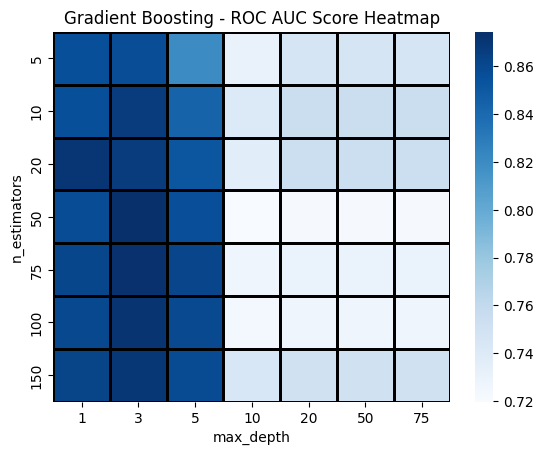

In [ ]:
gb_combo_avg_rocauc_lst = get_ROCAUC_for_each_combo(gb_combos, create_gb_classifier_model, data)

title = "Gradient Boosting - ROC AUC Score Heatmap"
plot_heatmap(gb_combo_avg_rocauc_lst, param1_name="n_estimators", param2_name="max_depth",
             title=title)

As we can see, the best combination is at the buttom-left region.

Let us find the exact best combination:

In [ ]:
display_best_combo(gb_combo_avg_rocauc_lst, "Gradient Boosting", "Number of Estimators", "Max Depth", "ROC AUC")

------------Gradient Boosting------------
Best Number of Estimators: 50
Best Max Depth: 3
Best ROC AUC: 0.874


Lastly, let us plot the propensity score histograms for both groups:

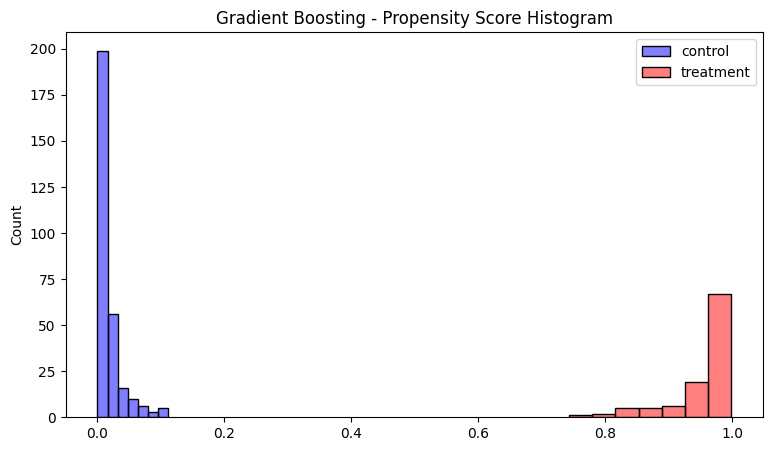

In [ ]:
best_gb_model = GradientBoostingClassifier(n_estimators=250, max_depth=3, random_state=123)
plot_propensity_score_histograms(best_gb_model, data, model_name="Gradient Boosting")

As we can, the Overlap requirement clearly does not hold at all.

### **Calculating the ATE**

Let us summarize the results of each architecture's best model:

| Architecture  | ROC AUC |
|----------|----------|
| Logistic Regression   |0.867  |
| Random Forest  | 0.84 |
| Gradient Boosting  |0.874  |

It appears that the Gradient Boosting architecture achieved the best performance. However, we can see that the Overlap requirement does not hold for it. Therefore, although that model is the best performing one (w.r.t. ROC AUC), it might yield a poor ATE estimation.

Thus, we will choose to use the Logisitic Regression model, which yielded the second best result (its score is lower only by a small margin), and it satisfies the Overlap requirement.

As a result, for the IPW method, we will use the following model:

**Logistic Regression with ```C=0.05``` and ```penalty='l1'```**.

In [18]:
def get_best_propensity_score_model_trained(data):
  X, y = get_IPW_X_y(data)

  # fit the propensity score model
  best_propensity_score_model = LogisticRegression(C=0.05, penalty="l1", solver="liblinear",
                                                   max_iter=5000, class_weight="balanced", random_state=123)
  best_propensity_score_model.fit(X, y)

  return best_propensity_score_model

def get_IPW_yearly_ATEs(data):
  # get the best propensity score model (trained)
  best_propensity_score_model = get_best_propensity_score_model_trained(data)

  IPW_year_ATE_lst = []
  for year in YEARS:
    # get the yearly data
    year_data = data[data["Year"] == year]

    # get observed outcome
    y = year_data["Inflation Rate"]

    # get treatment
    t = year_data["Is Election Year"]

    # estimate propensity score
    X = year_data.drop(["Country", "Is Election Year", "Inflation Rate"], axis=1)
    prop_scores = best_propensity_score_model.predict_proba(X)[:, 1]

    summ_year_0, summ_year_1 = 0, 0
    total_weight_0, total_weight_1 = 0, 0
    for yi, ti, prop_score in zip(y, t, prop_scores):

      # calculate each group yearly sum
      summ_year_0 += ((1 - ti) * yi) / (1 - prop_score)
      summ_year_1 += (ti * yi) / prop_score

      # calculate each group total weight
      total_weight_0 += (1 - ti) / (1 - prop_score)
      total_weight_1 += ti / prop_score

    # calculate each group yearly average
    avg_year_0 = summ_year_0 / total_weight_0
    avg_year_1 = summ_year_1 / total_weight_1

    # calculate the current yearly ATE
    year_ATE = avg_year_1 - avg_year_0
    IPW_year_ATE_lst.append(year_ATE)

  return IPW_year_ATE_lst

In [19]:
IPW_year_ATE_lst = get_IPW_yearly_ATEs(data)

# calculate the ATE as the average of the yearly ATEs
IPW_ATE = sum(IPW_year_ATE_lst) / len(IPW_year_ATE_lst)

print(f"ATE using the IPW method: {IPW_ATE:.3f}")

ATE using the IPW method: 0.009


Now, let us find a 95% confidence interval for this result:

In [ ]:
IPW_yearly_ATE_CIs, IPW_ATE_CI = get_CI_bootstrap(data, get_IPW_yearly_ATEs, B=500)

lower, upper = IPW_ATE_CI
print(f"95% confidence interval for the ATE: [{lower:.3f}, {upper:.3f}]")

95% confidence interval for the ATE: [-0.237, 0.261]


Lastly, let us plot the yearly ATEs, along with their respective 95% confidence intervals:

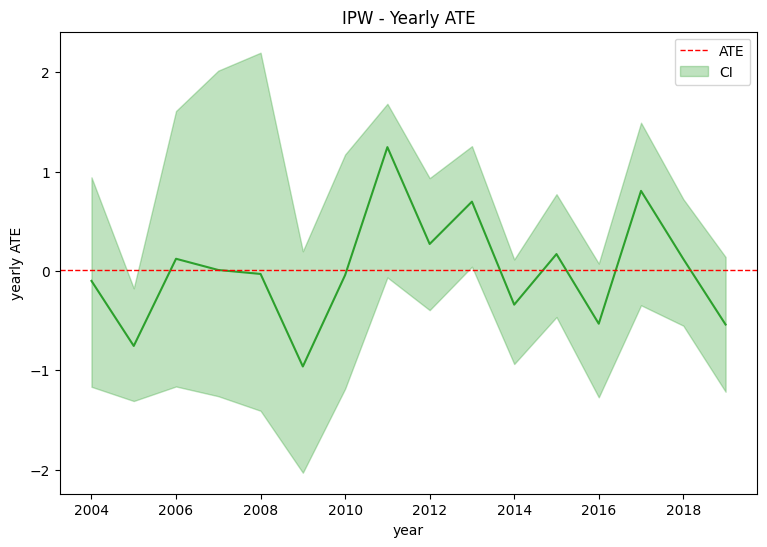

In [ ]:
plot_yearly_ATE(IPW_year_ATE_lst, IPW_ATE, IPW_yearly_ATE_CIs, method="IPW", color=COLORS[2])

## **DR-Learner**

This method combines both regression estimates, as well as propensity score estimates, into a single prediction. It theoretically ensures that the prediction is consistent even if only one of the estimates (either the regression or the propensity score estimates) is consistent.

To implement this method, we will utilize the best performing models obtained from the T-Learner and IPW sections.


In [20]:
def get_DR_learner_yearly_ATEs(data):
  # # get best propensity score model (trained)
  best_propensity_score_model = get_best_propensity_score_model_trained(data)

  # # get best T-learner models (trained)
  T_learner_best_model_0 = get_best_T_learner_model_trained(data, t=0)
  T_learner_best_model_1 = get_best_T_learner_model_trained(data, t=1)

  DR_learner_year_ATE_lst = []
  for year in YEARS:
    # get yearly data
    year_data = data[data["Year"] == year]
    year_summ = 0

    for _, row in year_data.iterrows():

      # get treatment
      t = row["Is Election Year"]

      # get outcome
      y = row["Inflation Rate"]

      # get confounders
      x = pd.DataFrame(row.drop(["Country", "Is Election Year", "Inflation Rate"])).T

      # estiamte propensity score
      prop_score = best_propensity_score_model.predict_proba(x)[0][1]

      # predict each group outcome
      y0_pred = T_learner_best_model_0.predict(x)[0]
      y1_pred = T_learner_best_model_1.predict(x)[0]

      # calculate each group method estimation
      g0 = y0_pred + ((1-t) / (1-prop_score))*(y - y0_pred)
      g1 = y1_pred + (t / prop_score)*(y - y1_pred)

      # sum the difference
      year_summ += (g1 - g0)

    # calculate the current yearly ATE
    year_ATE = year_summ / len(year_data)
    DR_learner_year_ATE_lst.append(year_ATE)

  return DR_learner_year_ATE_lst

In [21]:
DR_learner_year_ATE_lst = get_DR_learner_yearly_ATEs(data)

# calculate the average difference across the all the years
DR_learner_ATE = sum(DR_learner_year_ATE_lst) / len(DR_learner_year_ATE_lst)

print(f"ATE using the DR-Learner method: {DR_learner_ATE:.3f}")

ATE using the DR-Learner method: 0.065


Now, let us find a 95% confidence interval for this result:

In [ ]:
DR_learner_yearly_ATE_CIs, DR_learner_ATE_CI = get_CI_bootstrap(data, get_DR_learner_yearly_ATEs, B=500)

lower, upper = DR_learner_ATE_CI
print(f"95% confidence interval for the ATE: [{lower:.3f}, {upper:.3f}]")

95% confidence interval for the ATE: [-0.118, 0.234]


Lastly, let us plot the yearly ATEs, along with their respective 95% confidence intervals:

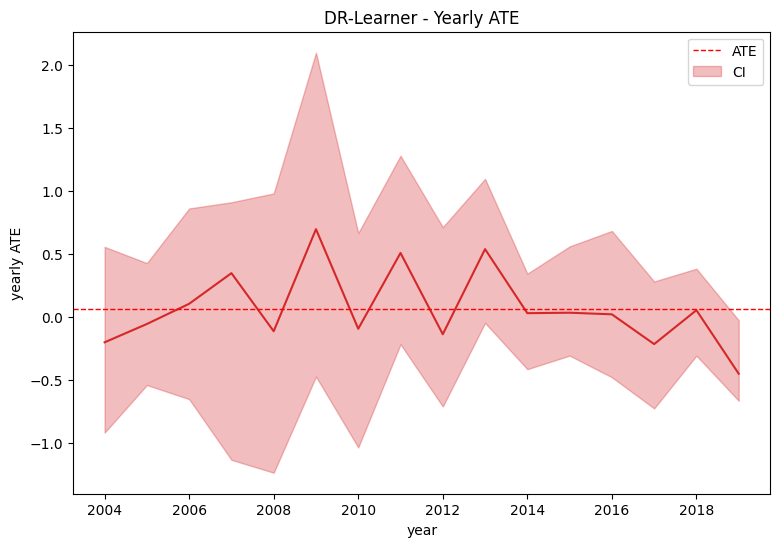

In [ ]:
plot_yearly_ATE(DR_learner_year_ATE_lst, DR_learner_ATE, DR_learner_yearly_ATE_CIs, method="DR-Learner", color=COLORS[3])

## **X-Learner**

In this method, for each instance, we fit two ML models to predict the treatment effect had it been in either group. Then, the instance’s treatment effect is calculated as the weighted sum of the predicted differences. In particular, we perform the following steps:

1. Predict each instance's opposite group outcome, utilizing the best achieved T-Learner models.

2. Calculate the corresponding difference between the observed outcome and the predicted outcome and associate it with one of the following groups:

	- D_0 - the differences of control group instances
	- D_1 - the differences of treatment group instances

3. Fit two ML models using all confounders as features, and D_0 and D_1 as target values, respectively.

4. Predict each instance's propensity score, utilizing the best achieved propensity score model.

5. Calculate each instance's treatment effect as the weighted sum of the two models' predictions, with the weights being the corresponding treatment probabilities. Formally:

  $D\hat(X_i) = e\hat(X_i)*D_1\hat(X_i) + (1 - e\hat(X_i))*D_0\hat(X_i)$


We will experiment with the following ML architectures:

- Random Forest

- AdaBoost

- Gradient Boosting

Moreover, we will use the same architecture for the two models, and fine-tine them separately, for the reasons mentioned previously.

*Note that again we do not consider the linear regression model, from the same reasons discussed in the previous sections.

Let us define a helper function to assist us in the fine-tuning process:

In [22]:
def get_D_learner_RMSE_for_each_combo(combos, create_model, data, t):
  group_data = data[data["Is Election Year"] == t]
  group_X, group_y = get_T_learner_X_y(group_data)

  opposite_group_T_learner = get_best_T_learner_model_trained(data, t=(1-t))
  opposite_group_y_pred = opposite_group_T_learner.predict(group_X)

  if t == 0:
    group_d = opposite_group_y_pred - group_y

  else:
    group_d = group_y - opposite_group_y_pred

  avg_rmse_lst = []
  for i, combo in enumerate(combos):
    summ = 0
    for seed in range(SEED_NUM):
      X_train, X_test, y_train, y_test = train_test_split(group_X, group_d, test_size=0.2, random_state=seed)

      model = create_model(combo, seed)
      rmse = get_RMSE_score(model, X_train, y_train, X_test, y_test)
      summ += rmse

    avg_rmse = summ / SEED_NUM
    avg_rmse_lst.append((combo, avg_rmse))

  return avg_rmse_lst

### **Random Forest**

For this architecture, we will consider fine-tuning the following parameters:

- Number of Trees

- Max Depth

First, let us define the desired parameter combinations:

In [ ]:
n_estimators_lst = [10, 100, 250, 500, 750, 1000]
max_depth_lst = [1, 5, 10, 35, 50, 75]

rf_combos = get_all_combos([n_estimators_lst, max_depth_lst])

Now, let us find each combination's average RMSE score and plot the results:

**Control Group:**

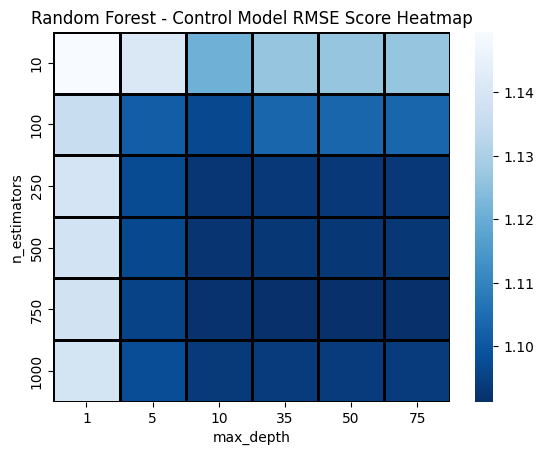

In [ ]:
control_rf_combo_avg_rmse_lst = get_D_learner_RMSE_for_each_combo(rf_combos, create_rf_regressor_model, data, t=0)

title = "Random Forest - Control Model RMSE Score Heatmap"
plot_heatmap(control_rf_combo_avg_rmse_lst, param1_name="n_estimators", param2_name="max_depth",
             title=title, reverse=True)

As we can see, the best combination is at the buttom-right region.

Let us find the exact best combination:

In [ ]:
display_best_combo(control_rf_combo_avg_rmse_lst, "Random Forest", "Number of Estimators", "Max Depth", "RMSE")

------------Random Forest------------
Best Number of Estimators: 750
Best Max Depth: 35
Best RMSE: 1.091


**Treatment Group:**

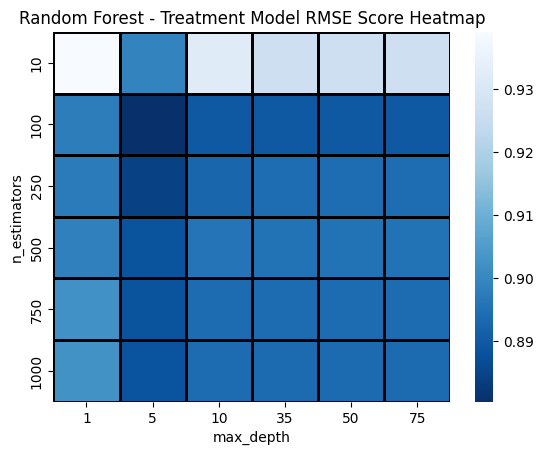

In [ ]:
treatment_rf_combo_avg_rmse_lst = get_D_learner_RMSE_for_each_combo(rf_combos, create_rf_regressor_model, data, t=1)

title = "Random Forest - Treatment Model RMSE Score Heatmap"
plot_heatmap(treatment_rf_combo_avg_rmse_lst, param1_name="n_estimators", param2_name="max_depth",
             title=title, reverse=True)

As we can see, the best combination is at the top-left region.

Let us find the exact best combination:

In [ ]:
display_best_combo(treatment_rf_combo_avg_rmse_lst, "Random Forest", "Number of Estimators", "Max Depth", "RMSE")

------------Random Forest------------
Best Number of Estimators: 100
Best Max Depth: 5
Best RMSE: 0.880


### **Adaboost**

For this architecture, we will consider fine-tuning the following parameters:

- Weak Learner Estimator

- Number of Estimators

First, let us define the desired parameter combinations:

In [ ]:
weak_learner_model_lst = [DecisionTreeRegressor(max_depth=1), DecisionTreeRegressor(max_depth=2),
                          DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=5),
                          DecisionTreeRegressor(max_depth=7), DecisionTreeRegressor(max_depth=10)]

n_estimators_lst = [10, 100, 200, 250, 500, 750]

ab_combos = get_all_combos([weak_learner_model_lst, n_estimators_lst])

Now, let us find each combination's average RMSE score and plot the results:

**Control Group:**

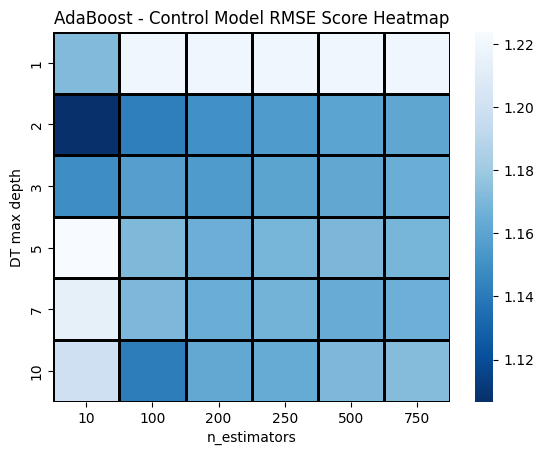

In [ ]:
control_ab_combo_avg_rmse_lst = get_D_learner_RMSE_for_each_combo(ab_combos, create_ab_regressor_model, data, t=0)
control_ab_combo_avg_rmse_lst = [((x[0][0].max_depth, x[0][1]), x[1]) for x in control_ab_combo_avg_rmse_lst]

title = "AdaBoost - Control Model RMSE Score Heatmap"
plot_heatmap(control_ab_combo_avg_rmse_lst, param1_name="DT max depth", param2_name="n_estimators",
             title=title, reverse=True)

As we can see, the best combination is at the top-left region.

Let us find the exact best combination:

In [ ]:
display_best_combo(control_ab_combo_avg_rmse_lst, "AdaBoost", "DT Max Depth", "Number of Estimators", "RMSE")

------------AdaBoost------------
Best DT Max Depth: 2
Best Number of Estimators: 10
Best RMSE: 1.107


**Treatment Group:**

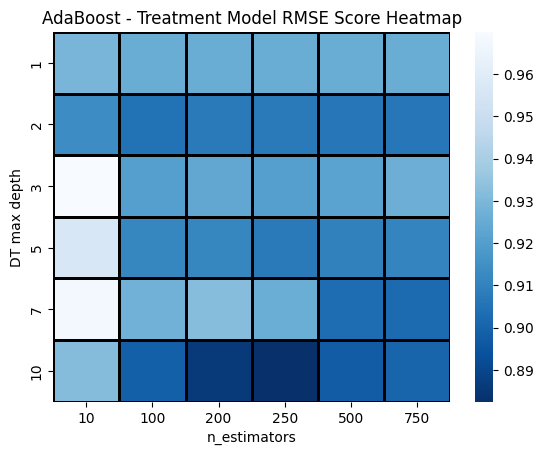

In [ ]:
treatment_ab_combo_avg_rmse_lst = get_D_learner_RMSE_for_each_combo(ab_combos, create_ab_regressor_model, data, t=1)
treatment_ab_combo_avg_rmse_lst = [((x[0][0].max_depth, x[0][1]), x[1]) for x in treatment_ab_combo_avg_rmse_lst]

title = "AdaBoost - Treatment Model RMSE Score Heatmap"
plot_heatmap(treatment_ab_combo_avg_rmse_lst, param1_name="DT max depth", param2_name="n_estimators",
             title=title, reverse=True)

As we can see, the best combination is at the buttom-middle region.

Let us find the exact best combination:

In [ ]:
display_best_combo(treatment_ab_combo_avg_rmse_lst, "AdaBoost", "DT Max Depth", "Number of Estimators", "RMSE")

------------AdaBoost------------
Best DT Max Depth: 10
Best Number of Estimators: 250
Best RMSE: 0.882


### **Gradient Boosting**

For this architecture, we will consider fine-tuning the following parameters:

- Number of Estimators

- Max Depth

First, let us define the desired parameter combinations:

In [ ]:
n_estimators_lst = [5, 10, 20, 50, 75, 100, 150]
max_depth_lst = [1, 3, 5, 10, 20, 50, 75]

gb_combos = get_all_combos([n_estimators_lst, max_depth_lst])

Now, let us find each combination's average RMSE score and plot the results:

**Control Group:**

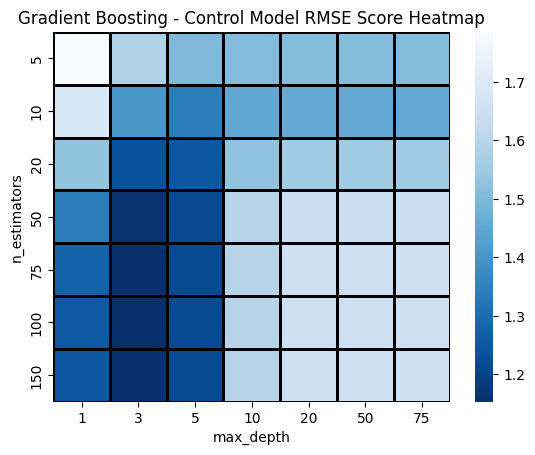

In [ ]:
control_gb_combo_avg_rmse_lst = get_T_learner_RMSE_for_each_combo(gb_combos, create_gb_regressor_model, data, t=0)

title = "Gradient Boosting - Control Model RMSE Score Heatmap"
plot_heatmap(control_gb_combo_avg_rmse_lst, param1_name="n_estimators", param2_name="max_depth",
             title=title, reverse=True)

As we can see, the best combination is at the buttom-left region.

Let us find the exact best combination:

In [ ]:
display_best_combo(control_gb_combo_avg_rmse_lst, "Gradient Boosting", "Number of Estimators", "Max Depth", "RMSE")

------------Gradient Boosting------------
Best Number of Estimators: 100
Best Max Depth: 3
Best RMSE: 1.153


**Treatment Group:**

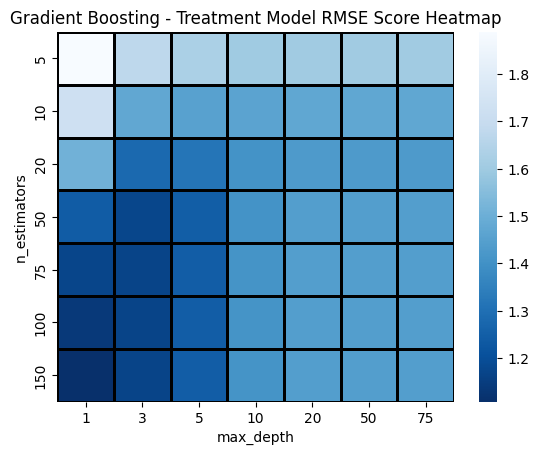

In [ ]:
treatment_gb_combo_avg_rmse_lst = get_T_learner_RMSE_for_each_combo(gb_combos, create_gb_regressor_model, data, t=1)

title = "Gradient Boosting - Treatment Model RMSE Score Heatmap"
plot_heatmap(treatment_gb_combo_avg_rmse_lst, param1_name="n_estimators", param2_name="max_depth",
             title=title, reverse=True)

As we can see, the best combination is at the buttom-left region.

Let us find the exact best combination:

In [ ]:
display_best_combo(treatment_gb_combo_avg_rmse_lst, "Gradient Boosting", "Number of Estimators", "Max Depth", "RMSE")

------------Gradient Boosting------------
Best Number of Estimators: 150
Best Max Depth: 1
Best RMSE: 1.108


### **Calculating the ATE**

Let us summarize the results of each architecture's best model:

| Architecture   | RMSE Control | RMSE Treatment | RMSE Average |
|----------|----------|----------|----------|
| Random Forest|1.091  |0.88|0.9855|
| AdaBoost |1.107| 0.882|0.9945|
| Gradient Boosting  |1.153|1.108|1.1305|

As we can see, the Random Forest architecture achieved the best performance.

As a result, for the T-learner method, we will use the Random Forest model with:

- **Control - ```n_estimator=750``` and ```max_depth=35```**

- **Treatment - ```n_estimator=100``` and ```max_depth=5```**

In [23]:
def get_best_D_learner_model_trained(data, t):
  group_data = data[data["Is Election Year"] == t]
  group_X, group_y = get_T_learner_X_y(group_data)

  opposite_group_T_learner = get_best_T_learner_model_trained(data, t=(1-t))
  opposite_group_y_pred = opposite_group_T_learner.predict(group_X)

  # control group
  if t == 0:
    group_d = opposite_group_y_pred - group_y
    best_D_learner_model = RandomForestRegressor(n_estimators=750, max_depth=35, random_state=123)

  # treatment group
  else:
    group_d = group_y - opposite_group_y_pred
    best_D_learner_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=123)

  # fit the model
  best_D_learner_model.fit(group_X, group_d)

  return best_D_learner_model

def get_X_learner_yearly_ATEs(data):
  # get best propensity score model (tranied)
  best_propensity_score_model = get_best_propensity_score_model_trained(data)

  # get best tranied D-learner models (trained)
  D_learner_best_model_0 = get_best_D_learner_model_trained(data, t=0)
  D_learner_best_model_1 = get_best_D_learner_model_trained(data, t=1)

  X_learner_year_ATE_lst = []
  for year in YEARS:
    # get yearly data
    year_data = data[data["Year"] == year]
    year_summ = 0

    for _, row in year_data.iterrows():

      # get confounders
      x = pd.DataFrame(row.drop(["Country", "Is Election Year", "Inflation Rate"])).T

      # estiamte propensity score
      prop_score = best_propensity_score_model.predict_proba(x)[0][1]

      # predict each group difference
      d0_pred = D_learner_best_model_0.predict(x)[0]
      d1_pred = D_learner_best_model_1.predict(x)[0]

      # sum the difference (weighted sum of the predicated differences)
      year_summ += (prop_score * d1_pred) + ((1-prop_score) * d0_pred)

    # calculate the current yearly ATE
    year_ATE = year_summ / len(year_data)
    X_learner_year_ATE_lst.append(year_ATE)

  return X_learner_year_ATE_lst

In [24]:
X_learner_year_ATE_lst = get_X_learner_yearly_ATEs(data)

# calculate the ATE as the average yearly ATEs
X_learner_ATE = sum(X_learner_year_ATE_lst) / len(X_learner_year_ATE_lst)

print(f"ATE using the X-Learner method: {X_learner_ATE:.3f}")

ATE using the X-Learner method: 0.035


Now, let us find a 95% confidence interval for this result:

In [ ]:
X_learner_yearly_ATE_CIs, X_learner_ATE_CI = get_CI_bootstrap(data, get_X_learner_yearly_ATEs, B=500)

lower, upper = X_learner_ATE_CI
print(f"95% confidence interval for the ATE: [{lower:.3f}, {upper:.3f}]")

95% confidence interval for the ATE: [-0.134, 0.218]


Lastly, let us plot the yearly ATEs, along with their respective 95% confidence intervals:

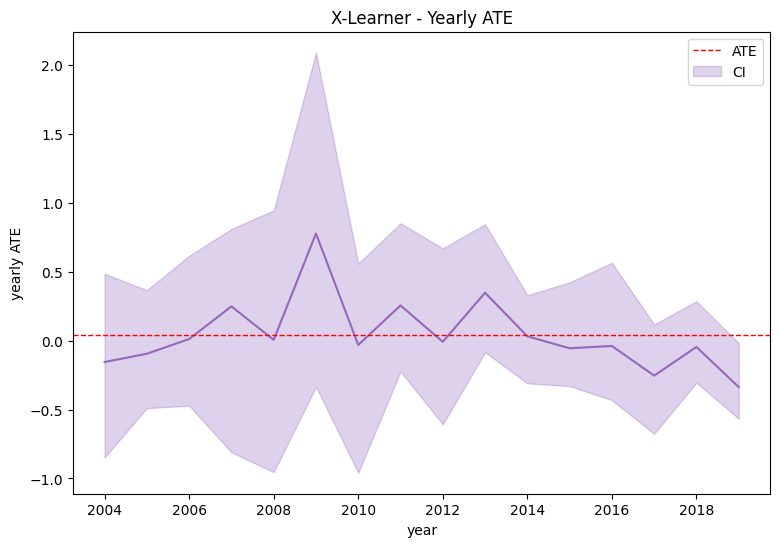

In [ ]:
plot_yearly_ATE(X_learner_year_ATE_lst, X_learner_ATE, X_learner_yearly_ATE_CIs, method="X-Learner", color=COLORS[4])

## **Matching**

For this method, for each instance, we estimate the outcome variable of the opposite treatment group, by aggregating a number (K) of the most similar instances in that group. Rather than using K=1, we will fine-tune for the value of K. Moreover, to best capture the characteristics of each group, we fit two separate models, one for each group, and fine-tune them separately.

In order to measure similarity between instances, we will calculate the distance between their confounder vectors. We will explore several distance metrics:

- Euclidean distance
- Manhattan distance
- Cosine distance

As a means to obtain our goal in a computationally efficient manner, we will utilize the KNN regression algorithm.

Moreover, we will use the same distance metric for the two models, for the reasons mentioned previously.

*Note that the confounders' values vary in scale. Therefore, before using the KNN model, we will need to scale and normalize the data.

Let us define a helper function to assist us in the fine-tuning process:

In [25]:
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

### helper functions
def get_matching_X_y(data):
  matching_X = data.drop(["Country", "Inflation Rate"], axis=1)
  matching_y = data["Inflation Rate"]

  return matching_X, matching_y

def process_data(X_train, X_test):
  X_train = X_train.drop("Is Election Year", axis=1)
  X_test = X_test.drop("Is Election Year", axis=1)

  scaler = MinMaxScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  normalizer = Normalizer()
  X_train = normalizer.fit_transform(X_train)
  X_test = normalizer.fit_transform(X_test)

  return X_train, X_test

def get_RMSE_for_each_k(k_vals, distance_metric, data, t):
  data_T = data[data["Is Election Year"] == t]
  X, y = get_matching_X_y(data_T)

  avg_rmse_lst = []
  for k in k_vals:

    rmse_summ = 0
    for seed in range(SEED_NUM):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed,
                                                          stratify=X["Is Election Year"])

      knn = KNeighborsRegressor(n_neighbors=k, metric=distance_metric)
      X_train, X_test = process_data(X_train, X_test)
      rmse = get_RMSE_score(knn, X_train, y_train, X_test, y_test)

      rmse_summ += rmse

    avg_rmse = rmse_summ / SEED_NUM
    avg_rmse_lst.append((k, avg_rmse))

  return avg_rmse_lst

def plot_knn_results(avg_rmse_lst, title):
  k_vals = [x[0] for x in avg_rmse_lst]
  rmse_vals = [x[1] for x in avg_rmse_lst]

  plt.figure(figsize=(9, 5))
  plt.plot(k_vals, rmse_vals)
  plt.title(title)
  plt.xticks(k_vals)
  plt.xlabel("K")
  plt.ylabel("RMSE")
  plt.show()

def display_metric_best_results(avg_rmse_lst, metric_name):

  best_k, best_rmse = min(avg_rmse_lst, key=lambda x: x[1])

  print(f"------------{metric_name} Distance------------")
  print(f"Best K: {best_k}")
  print(f"Best RMSE: {best_rmse:.3f}")

### **Euclidean Distance**

Let us define the hyper-parameters values:

In [ ]:
k_vals = [k for k in range(1, 21)]
distance_metric = "euclidean"

Now, let us find each K's average RMSE score for each group:

**Control Group:**

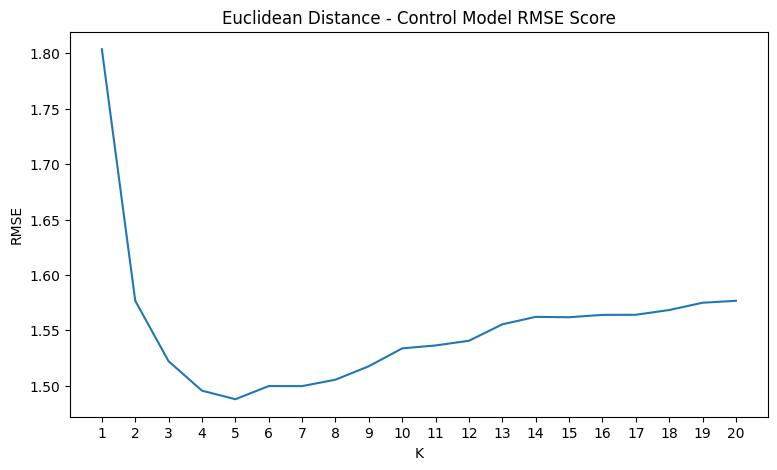

In [ ]:
control_euclidean_avg_rmse_lst = get_RMSE_for_each_k(k_vals, distance_metric, data, t=0)

title = "Euclidean Distance - Control Model RMSE Score"
plot_knn_results(control_euclidean_avg_rmse_lst, title)

In [ ]:
display_metric_best_results(control_euclidean_avg_rmse_lst, metric_name="Euclidean")

------------Euclidean Distance------------
Best K: 5
Best RMSE: 1.488


**Treatment Group:**

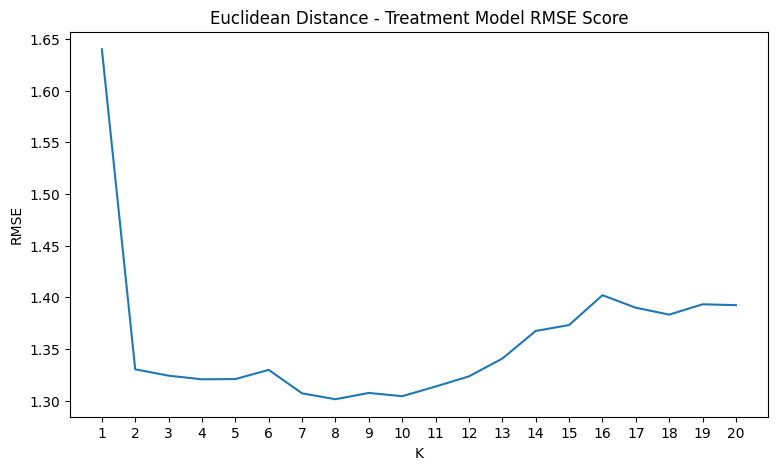

In [ ]:
treatment_euclidean_avg_rmse_lst = get_RMSE_for_each_k(k_vals, distance_metric, data, t=1)

title = "Euclidean Distance - Treatment Model RMSE Score"
plot_knn_results(treatment_euclidean_avg_rmse_lst, title)

In [ ]:
display_metric_best_results(treatment_euclidean_avg_rmse_lst, metric_name="Euclidean")

------------Euclidean Distance------------
Best K: 8
Best RMSE: 1.301


### **Manhattan Distance**

Let us define the hyper-parameters values:

In [ ]:
k_vals = [k for k in range(1, 21)]
distance_metric = "manhattan"

Let us find each K's average RMSE score for each group:

**Control Group:**

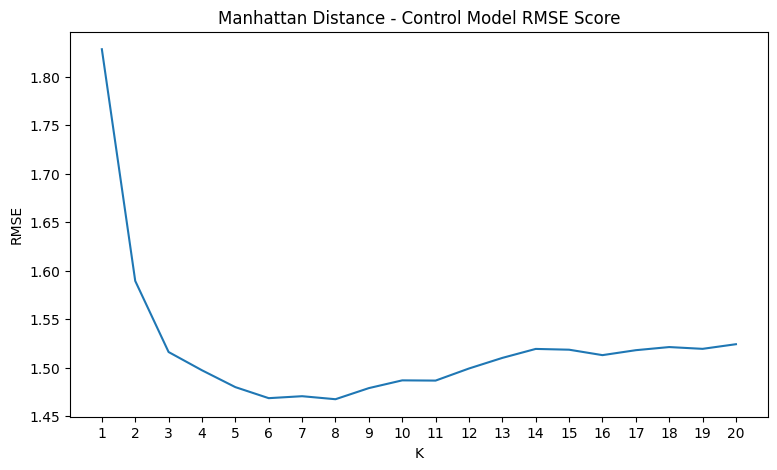

In [ ]:
control_manhattan_avg_rmse_lst = get_RMSE_for_each_k(k_vals, distance_metric, data, t=0)

title = "Manhattan Distance - Control Model RMSE Score"
plot_knn_results(control_manhattan_avg_rmse_lst, title)

In [ ]:
display_metric_best_results(control_manhattan_avg_rmse_lst, metric_name="Manhattan")

------------Manhattan Distance------------
Best K: 8
Best RMSE: 1.467


**Treatment Group:**

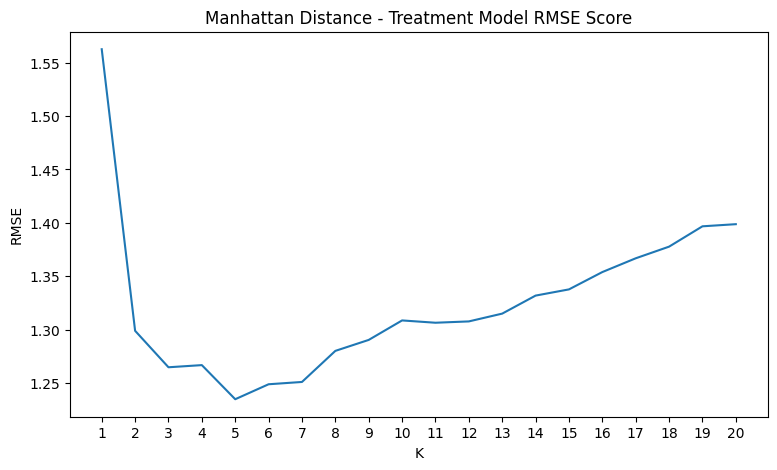

In [ ]:
treatment_manhattan_avg_rmse_lst = get_RMSE_for_each_k(k_vals, distance_metric, data, t=1)

title = "Manhattan Distance - Treatment Model RMSE Score"
plot_knn_results(treatment_manhattan_avg_rmse_lst, title)

In [ ]:
display_metric_best_results(treatment_manhattan_avg_rmse_lst, metric_name="Manhattan")

------------Manhattan Distance------------
Best K: 5
Best RMSE: 1.235


### **Cosine Distance**

Let us define the hyper-parameters values:

In [ ]:
k_vals = [k for k in range(1, 21)]
distance_metric = "cosine"

Let us find each K's average RMSE score for each group:

**Control Group:**

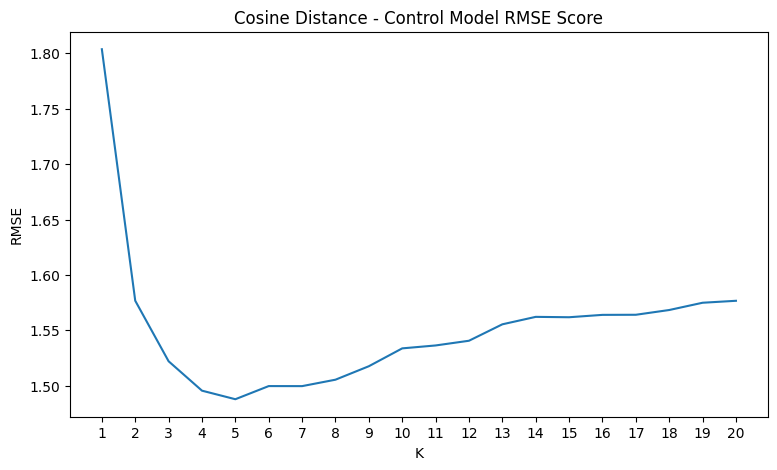

In [ ]:
control_cosine_avg_rmse_lst = get_RMSE_for_each_k(k_vals, distance_metric, data, t=0)

title = "Cosine Distance - Control Model RMSE Score"
plot_knn_results(control_cosine_avg_rmse_lst, title)

In [ ]:
display_metric_best_results(control_cosine_avg_rmse_lst, metric_name="Cosine")

------------Cosine Distance------------
Best K: 5
Best RMSE: 1.488


**Treatment Group:**

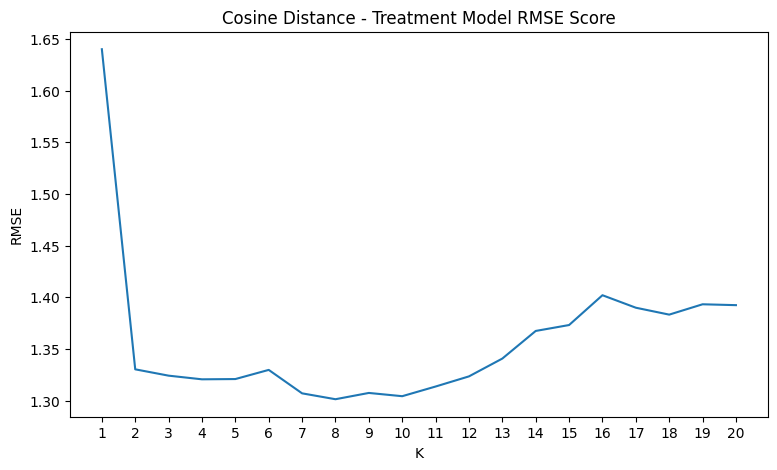

In [ ]:
treatment_cosine_avg_rmse_lst = get_RMSE_for_each_k(k_vals, distance_metric, data, t=1)

title = "Cosine Distance - Treatment Model RMSE Score"
plot_knn_results(treatment_cosine_avg_rmse_lst, title)

In [ ]:
display_metric_best_results(treatment_cosine_avg_rmse_lst, metric_name="Cosine")

------------Cosine Distance------------
Best K: 8
Best RMSE: 1.301


### **Calculating the ATE**

Let us summarize the results of each metric's best model:

| Distance Metric | RMSE Control| RMSE Treatment | RMSE Average |
|-----------------|-------------|----------------|--------------|
| Euclidean       | 1.488       | 1.301          | 1.3945       |
| Manhattan       | 1.467       | 1.235          | 1.351       |
| Cosine          | 1.488       | 1.301          | 1.3945       |


As we can see, the Cosine Manhattan metric achieved the best average RMSE score. Moreover, it achieved the best performance on each group individually.

Hence, for the Matching method, we will choose the Manhattan metric distance with the following k values:
- **Control - K=8**
- **Treatment - K=5**


In [26]:
def get_outcomes(model, train_data, pred_data):
  X_train, y_train = get_matching_X_y(train_data)
  X_group, y_group = get_matching_X_y(pred_data)

  X_train, X_group = process_data(X_train, X_group)

  model.fit(X_train, y_train)
  y_pred_opposit_group = model.predict(X_group)

  return np.array(y_group), np.array(y_pred_opposit_group)

def get_matching_yearly_ATEs(data):
  # divide the data to control and treatment groups
  data_t0 = data[data["Is Election Year"] == 0]
  data_t1 = data[data["Is Election Year"] == 1]

  # initialize best matching model of the control group
  best_matching_model_T0 = KNeighborsRegressor(n_neighbors=8, metric="manhattan")

  # initialize best matching model of the treatment group
  best_matching_model_T1 = KNeighborsRegressor(n_neighbors=5, metric="manhattan")

  matching_year_ATE_lst = []
  for year in YEARS:
    # get yearly data
    year_data = data[data["Year"] == year]

    # get control group true outcomes and predicted outcomes (for the treatment group)
    year_data0 = year_data[year_data["Is Election Year"] == 0]
    y0, y1_preds = get_outcomes(best_matching_model_T1, train_data=data_t1, pred_data=year_data0)

    # get treatment group true outcomes and predicted outcomes (for the control group)
    year_data1 = year_data[year_data["Is Election Year"] == 1]
    y1, y0_preds = get_outcomes(best_matching_model_T0, train_data=data_t0, pred_data=year_data1)

    # calculate the yearly summ - first element is the control sum, second element is the treatment sum
    year_summ = np.sum(y1_preds - y0) + np.sum(y1 - y0_preds)

    # calculate the current yearly ATE
    year_ATE = year_summ / len(year_data)
    matching_year_ATE_lst.append(year_ATE)

  return matching_year_ATE_lst

In [27]:
matching_year_ATE_lst = get_matching_yearly_ATEs(data)

# calculate the ATE as the average of the yearly ATEs
matching_ATE = sum(matching_year_ATE_lst) / len(matching_year_ATE_lst)

print(f"ATE using the Matching method: {matching_ATE:.3f}")

ATE using the Matching method: -0.071


Now, let us find a 95% confidence interval for this result:

In [ ]:
matching_yearly_ATE_CIs, matching_ATE_CI = get_CI_bootstrap(data, get_matching_yearly_ATEs, B=500)

lower, upper = matching_ATE_CI
print(f"95% confidence interval for the ATE: [{lower:.3f}, {upper:.3f}]")

95% confidence interval for the ATE: [-0.309, 0.176]


Lastly, let us plot the yearly ATEs, along with their respective 95% confidence intervals:

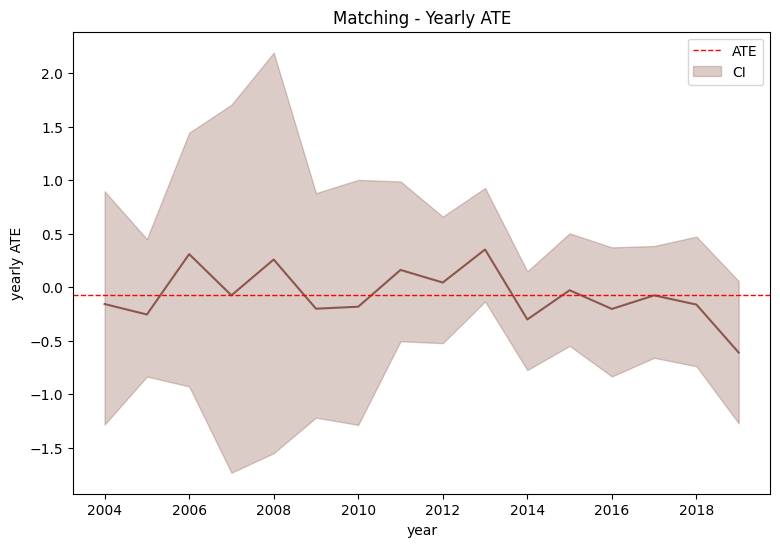

In [ ]:
plot_yearly_ATE(matching_year_ATE_lst, matching_ATE, matching_yearly_ATE_CIs, method="Matching", color=COLORS[5])

## **Analyzing the Results**

First, let us summarize the results of the previous sections:

| Method | ATE Estimation| 95% Confidence Interval|
|-----------------|-------------|----------------|
| S-Learner       | -0.002      | [-0.018, 0.027]         |
| T-Learner       | 0.036       | [-0.129, 0.219]          |
| IPW        | 0.009       | [-0.237, 0.261]         |
| DR-Learner       | 0.065     | [-0.118, 0.234]         |
| X-Learner       | 0.035     | [-0.134, 0.218]         |
| Matching       | -0.071      | [-0.309, 0.176]         |


Now, in order to better compare the six methods, let us disaply their results visually:

In [44]:
def plot_confidence_interval(ATE, ATE_CI, x):
  lower, upper = ATE_CI
  left = x - 0.08
  right = x + 0.08

  plt.plot([x, x], [upper, lower], color='black', linewidth=0.55)
  plt.plot([left, right], [upper, upper], color='black', linewidth=0.55)
  plt.plot([left, right], [lower, lower], color='black', linewidth=0.55)
  plt.plot(x, ATE, 'o', color='black', markersize=3)

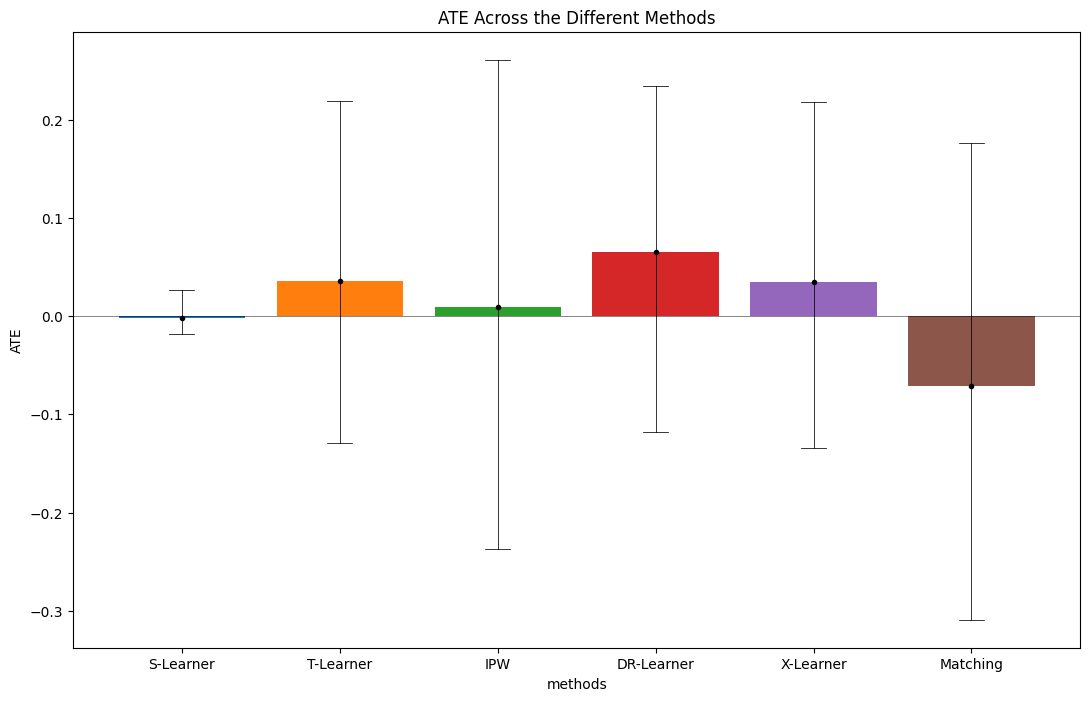

In [45]:
methods_ATE = np.array([S_learner_ATE, T_learner_ATE, IPW_ATE, DR_learner_ATE, X_learner_ATE, matching_ATE])
methods_ATE_CIs = np.array([S_learner_ATE_CI, T_learner_ATE_CI, IPW_ATE_CI, DR_learner_ATE_CI, X_learner_ATE_CI, matching_ATE_CI])

lower_errors = [ATE - ATE_CI[0] for ATE, ATE_CI in zip(methods_ATE, methods_ATE_CIs)]
upper_errors = [ATE_CI[1] - ATE for ATE, ATE_CI in zip(methods_ATE, methods_ATE_CIs)]

methods_names = ["S-Learner", "T-Learner", "IPW", "DR-Learner", "X-Learner", "Matching"]

plt.figure(figsize=(13, 8))
plt.title("ATE Across the Different Methods")
plt.ylabel("ATE")
plt.xlabel("methods")

plt.xticks([0, 1, 2, 3, 4, 5], ['S-Learner', 'T-Learner', 'IPW', 'DR-Learner', 'X-Learner', 'Matching'])
plt.axhline(y=0, color="black", linewidth="0.6", alpha=0.55)
plt.bar(methods_names, methods_ATE, color=COLORS)

for i, (method_ATE, method_CI) in enumerate(zip(methods_ATE, methods_ATE_CIs)):
  plot_confidence_interval(method_ATE, method_CI, i)

plt.show()

Now, let us comapre the yearly ATE of each of the methods:

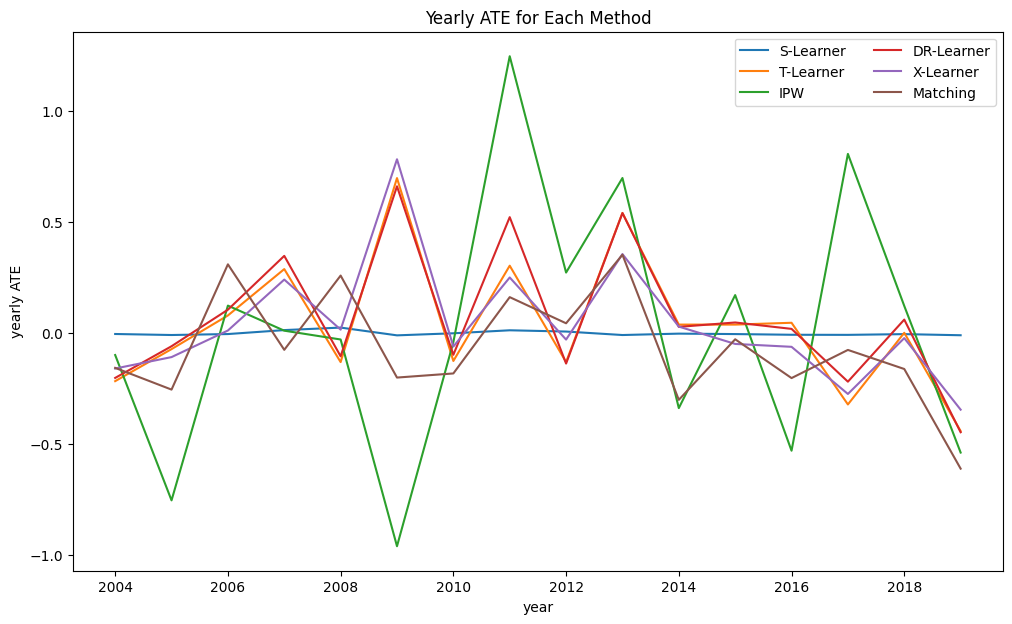

In [46]:
methods_year_ATE_lst = np.array([S_learner_year_ATE_lst, T_learner_year_ATE_lst, IPW_year_ATE_lst,
                                 DR_learner_year_ATE_lst, X_learner_year_ATE_lst, matching_year_ATE_lst])

plt.figure(figsize=(12, 7))
plt.title("Yearly ATE for Each Method")
plt.ylabel("yearly ATE")
plt.xlabel("year")

for method_ATE_lst, method_name, color in zip(methods_year_ATE_lst, methods_names, COLORS):
  plt.plot(YEARS, method_ATE_lst, label=method_name, color=color)

plt.legend(ncols=2)
plt.show()

Now, in order to recieve a single ATE estimation, let us aggregate the results by averaging across the six methods:

In [40]:
# average all methods results
final_ATE = methods_ATE.mean()

print(f"Final ATE: {final_ATE:.3f}")

Final ATE: 0.012


Now, let us find a 95% confidence interval for this result:

In [33]:
def get_final_yearly_ATEs(data):
  # define all of the methods in a list
  get_yearly_ATE_methods = [get_S_learner_yearly_ATEs, get_T_learner_yearly_ATEs, get_IPW_yearly_ATEs,
                            get_DR_learner_yearly_ATEs, get_X_learner_yearly_ATEs, get_matching_yearly_ATEs]

  yearly_ATE_methods_summ = np.zeros(len(YEARS))
  for get_yearly_ATE in get_yearly_ATE_methods:

    # get the current method yearly ATEs
    yearly_ATE_methods_summ += np.array(get_yearly_ATE(data))

  # calculate the final yearly ATEs as the average of the methods
  final_year_ATE_lst = yearly_ATE_methods_summ / len(get_yearly_ATE_methods)
  return final_year_ATE_lst

In [43]:
final_yearly_ATE_CIs, final_ATE_CI = get_CI_bootstrap(data, get_final_yearly_ATEs, B=500)

lower, upper = final_ATE_CI
print(f"95% confidence interval for the ATE: [{lower:.3f}, {upper:.3f}]")

95% confidence interval for the ATE: [-0.136, 0.158]


Lastly, let us display the final yearly ATE estimations:

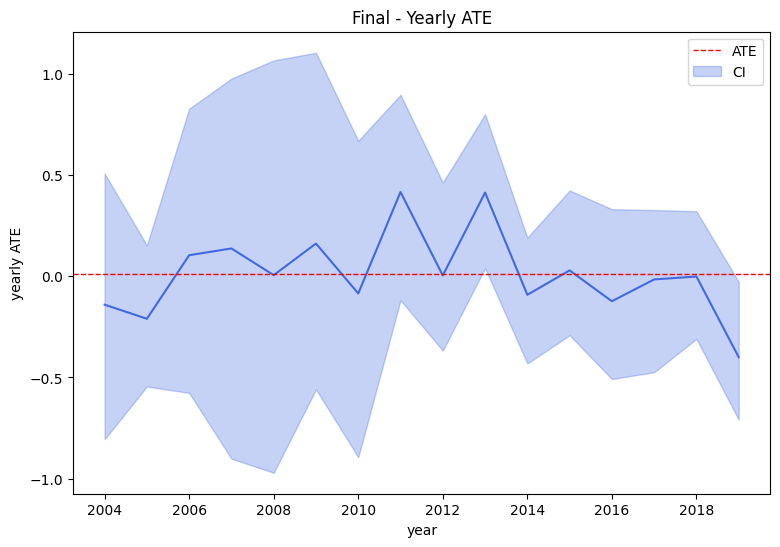

In [37]:
# get the final yearly ATE
final_year_ATE_lst = methods_year_ATE_lst.mean(axis=0)

plot_yearly_ATE(final_year_ATE_lst, final_ATE, final_yearly_ATE_CIs, method="Final", color="royalblue")